
# **Analyzing NYC Taxi Trips: Understanding Demand and Optimizing Revenue**


**IS843 - Team 6**

Gabriela Vargas Horle

Harshil Thakkar 

Heijang Wu 

Priyank Negi 

Wenxuan Yan

## **1. Introduction**

**Project objective:**<br>
Our exploration will enable us to identify taxi trip patterns in NYC and develop strategies accordingly to improve revenue for taxi drivers and taxi companies.

We combined datasets from 2018 to 2021 to draw more insight from our analysis. As data from 2020 onwards show the impact of the pandemic on taxi demand, providing information from the two years prior to the pandemic would lead to a more accurate interpretation of results.

For Phase 1 of our project we explored the data to understand commonalities in demand, depending on year, month, day of the week, time of the day and location. In Phase 2 we utilized our findings to discern further how those factors affect revenue.

**Motivation:**<br>
Taxi market has been facing great competition in recent years, as an increasing number of people switch from taxi to share-riding, such as Uber and Lyft, as a means of transportation. While taxi companies and drivers may have a hard time going through this transition, there are people who prefer and need to take taxis. By analyzing taxi trip patterns in NYC, we will help taxi companies and drivers learn more about the customers they're serving and, more importantly, how to increase revenue to stay in business.

The analysis revealed that taxi trips were most popular during the morning and afternoon hours. Short-distance trips were the most popular, with the most frequently traveled routes being in the upper east and upper west side, spanning 66 blocks. Long trips were found to be the most expensive per minute. In terms of difference in demand based on the day of the week; Friday has the highest demand, while Sunday has the lowest.

**Report Summary:**<br>
We cleaned the dataframe to exclude unrepresentative data points and created features that better fit the purpose of our analyses. We conducted exploratory data analysis on taxi trip demand patterns, revenue patterns, and how they interrelate to one another. We also implemented machine learning methods, including linear regression, random forest, and GBT regression, to predict taxi trip price based on other features.


## **2. Data source**

**Data Source:** <br>The datasets used were downloaded from BigQuery. The information in this dataset was made available by the New York City Taxi and Limousine Commission (TLC).

This project used datasets containing data regarding yellow taxi trips in New York City spanning from 2018 to 2021. We also used a taxi zone dataset to assign name locations to the zone_ids, which by itself, would not sufficiently contextualize the data. 

We decided not to include data from 2022 as early exploration of that dataset indicated that values from the month of December were missing from the original dataset featured on BigQuery.  

**Data dictionary**<br>
**taxi_zone_geom**

bigquery-public-data.new_york_taxi_trips.taxi_zone_geom

|Column Name|Description|Type|
|--|--|--|
|zone_id|Unique ID number of each taxi zone. Corresponds with the pickup_location_id and dropoff_location_id in each of the trips tables|STRING|
|zone_name|Full text name of the taxi zone|STRING|
|borough|Borough containing the taxi zone|STRING|
|zone_geom|Geometric outline that defines the taxi zone suitable for GIS analysis.|GEOGRAPHY|


**tlc_yellow_trips**

2018:
bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018

2019: 
bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2019

2020:
bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2020

2021:
bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2021

|Column Name|Description|Type|
|--|--|--|
|vendor_id|A code indicating the LPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.|STRING|
|pickup_datetime|The date and time when the meter was engaged|TIMESTAMP|
|dropoff_datetime|The date and time when the meter was disengaged|TIMESTAMP|
|passenger_count|The number of passengers in the vehicle. This is a driver-entered value.|INTEGER|
|trip_distance|The elapsed trip distance in miles reported by the taximeter.|NUMERIC|
|rate_code|The final rate code in effect at the end of the trip. 1= Standard rate 2=JFK 3=Newark 4=Nassau or Westchester 5=Negotiated fare 6=Group ride|STRING|
|store_and_fwd_flag|This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka 'store and forward,' because the vehicle did not have a connection to the server. Y= store and forward trip N= not a store and forward trip|STRING|
|payment_type|A numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip|STRING|
|fare_amount|The time-and-distance fare calculated by the meter|NUMERIC|
|extra|Miscellaneous extras and surcharges. Currently, this only includes the 0.50 and 1 dollar rush hour and overnight charges|NUMERIC|
|mta_tax|0.50 dollar MTA tax that is automatically triggered based on the metered rate in use|NUMERIC|
|tip_amount|Tip amount. This field is automatically populated for credit card tips. Cash tips are not included.|NUMERIC|
|tolls_amount|Total amount of all tolls paid in trip.|NUMERIC|
|imp_surcharge|0.30 dollar improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015.|NUMERIC|
|airport_fee|-|NUMERIC|
|total_amount|The total amount charged to passengers. Does not include cash tips.|NUMERIC|
|pickup_location_id|TLC Taxi Zone in which the taximeter was engaged|STRING|
|dropoff_location_id|TLC Taxi Zone in which the taximeter was disengaged|STRING|
|data_file_year|Datafile timestamp year value|INTEGER|
|data_file_month|Datafile timestamp month value|INTEGER|


## **3. Data Cleaning**

### **3.a. Loading the data into a Spark DataFrame**

In [1]:
data2021 = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_taxi_trips.tlc_yellow_trips_2021').load()
data2020 = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_taxi_trips.tlc_yellow_trips_2020').load()
data2019 = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_taxi_trips.tlc_yellow_trips_2019').load()
data2018 = spark.read.format('bigquery').option('table', 'bigquery-public-data:new_york_taxi_trips.tlc_yellow_trips_2018').load()
df_raw = data2021.union(data2020).union(data2019).union(data2018)
df_raw.printSchema()
df_raw.show(5)

In [2]:
df_raw = data2021.union(data2020).union(data2019).union(data2018)
df_raw.printSchema()
df_raw.show(5)



root
 |-- vendor_id: string (nullable = false)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: decimal(38,9) (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: decimal(38,9) (nullable = true)
 |-- extra: decimal(38,9) (nullable = true)
 |-- mta_tax: decimal(38,9) (nullable = true)
 |-- tip_amount: decimal(38,9) (nullable = true)
 |-- tolls_amount: decimal(38,9) (nullable = true)
 |-- imp_surcharge: decimal(38,9) (nullable = true)
 |-- airport_fee: decimal(38,9) (nullable = true)
 |-- total_amount: decimal(38,9) (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)
 |-- data_file_year: long (nullable = true)
 |-- data_file_month: long (nullable = true)



+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----------+-----------+-----------+------------+-------------+-----------+------------+------------------+-------------------+--------------+---------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type| fare_amount|      extra|    mta_tax| tip_amount|tolls_amount|imp_surcharge|airport_fee|total_amount|pickup_location_id|dropoff_location_id|data_file_year|data_file_month|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----------+-----------+-----------+------------+-------------+-----------+------------+------------------+-------------------+--------------+---------------+
|        1|2021-01-01 00:43:30|2021-01-01 01:11:06|              1| 14.700000000|      1.0|                 N|     

### **3.b. Dropping Unnecessary Columns**
The columns 'data_file_year' and 'data_file_month' are not of interest, so we drop them here.


In [181]:
df_raw = df_raw.drop('data_file_year','data_file_month')

In [182]:
df_raw.cache()

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string]

### **3.c. Handling missing values**

Here we sample a portion from the whole dataframe only for more efficient visualization of missing values. We'll conduct the actually data cleaning steps on the original dataframe based on the pattern observed from the sample. The sample is 0.05% of the entire dataframe, giving us over 0.1 million records. This sample is chosen to be this size for the purpose of efficient code execution.

In [183]:
df_raw_sample = df_raw.sample(False, 0.0005, 843)
df_raw_sample.cache()

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string]

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

Upon investigation, we find four columns with missing values, which are not missing at random. The observations of columns "passenger_count", and "rate_code" are missing only when "payment_type" is 0 and vice versa. Moreover, payment_type that has a value of 0 is not described in the data dictionary, so we will drop these rows.

In [185]:
# We drop the rows where "passenger_count", "store_and_fwd_flag", and "payment_type" have missing values
df_raw_sample = df_raw_sample.where(~(df_raw_sample['payment_type']==0))
df_raw = df_raw.where(~(df_raw_sample['payment_type']==0))

The airport_fee column had no values until a the end of March in 2021. We fill the missing values of "airport_fee" with -999 so we can keep the column for further analysis.

In [186]:
# We fill the missing values of "airport_fee" with -999 so we can keep the column for further analysis
df_raw = df_raw.fillna(-999,subset=['airport_fee'])

In [187]:
df_raw.cache()

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string]

### **3.d. Handling Outliers**

### 3.d.1. Handling outliers based on time and trip duration

In [188]:
from pyspark.sql.functions import year, hour, unix_timestamp, col, round
# Extract year as a column
df_raw = df_raw.withColumn('year',year(df_raw['pickup_datetime']))

As our dataset should only contain data from 2018 to 2021, we therefore drop all rows that are not within this year range.

In [189]:
# As our dataset should only contain data from 2018 to 2021, we therefore drop all rows for that are not within this year range
df_raw = df_raw.where((df_raw['year']==2021)|(df_raw['year']==2020)|(df_raw['year']==2019)|(df_raw['year']==2018))

Drop rows where pickup time is no earlier than dropoff time.

In [190]:
df_raw = df_raw.where(df_raw['pickup_datetime']<df_raw['dropoff_datetime'])

In the following step, we're handling outliers based on the common sense that most taxi trips wouldn't take extremely long hours. We'll calculate the duration in minutes for each taxi trip and eliminate data points that fall out of the range of mean +/- 2.5 standard deviations, as is often the convention in statistical analysis.

In [191]:
# Create a new column "duration" to represent the duration of each taxi trip
df_raw = df_raw.withColumn("duration", (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)

In [192]:
df_raw = df_raw.withColumn("duration", round(col("duration"), 2))

In [ ]:
# We exclude outliers where duration and speed are not within the range of mean plus/minus 2.5 standard deviations
std_duration = df_raw.agg({'duration': 'stddev'}).collect()[0][0]
mean_duration = df_raw.agg({'duration': 'mean'}).collect()[0][0]
hi_bound_duration = mean_duration + (2.5 * std_duration)
low_bound_duration = mean_duration - (2.5 * std_duration)
df_raw = df_raw.where((df_raw['duration']>low_bound_duration)&(df_raw['duration']<hi_bound_duration))

In [ ]:
df_raw.cache()

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string, year: int, duration: double]

### 3.d.2. Handling outliers based on price and rate code
Each taxi trip is priced according to a fixed set of rules, where the major component of pricing is attributed to distance-and-time fare calculated by the meter (in our dataset, the "fare_amount" variable). While other fees and surcharges also apply to some taxi trips, they only account for a much smaller portion of taxi pricing. Based on this knowledge, we will exliminate "abnormal" data points that don't follow such patterns.

We noticed there exist out-of-range values (the value "99.0", which is not a valid rate_code according to the data dictionary) and abnormal values (e.g. "1.0" and "1" exist at the same time) for the rate_code column, so we fix them here using the following code:

In [20]:
df_raw = df_raw.where((df_raw['rate_code'] != '99.0')&(df_raw['rate_code'] != '99'))

from pyspark.sql.functions import when
df_raw = df_raw.withColumn('rate_code', when(df_raw['rate_code']=='1.0','1')\
                                        .when(df_raw['rate_code']=='2.0','2')\
                                        .when(df_raw['rate_code']=='3.0','3')\
                                        .when(df_raw['rate_code']=='4.0','4')\
                                        .when(df_raw['rate_code']=='5.0','5')\
                                        .when(df_raw['rate_code']=='6.0','6')
                                        .otherwise(df_raw['rate_code']))

In [ ]:
df_raw.select(col('rate_code')).distinct().show()

+---------+
|rate_code|
+---------+
|        3|
|        5|
|        6|
|        1|
|        4|
|        2|
+---------+



In the next step, we create two plots describing the correlation between trip distance and distance-and-time calculated fare. The plot on the left-hand side is for all trips, including standard-rate trips, airport trips, and "negotiated price" trips. The plot on the right-hand side only includes standard-rate trips whose fare is calculated by the meter based on distance and time.
* When rate_code equals 1, the corresponding row represents a trip charging standard rate, meaning that the fare_amount column reflects a fare calculated based on distance and time. The base fare for such trips from 2018 to 2021 is \\$2.5. Each additional mile charges another \\$2.5 and each additional minute charges another \$0.5. Therefore, the correlation between trip distance and fare_amount should be linear with a slope equal to or above 2.5.
* When rate_code is 2 or 3 or 4, the corresponding row represents an airport taxi trip that uses a different base fare from standard rate. For example, there is a flat rate of \$52 for trips between Manhattan to JFK airport, and such trips have a rate_code of 2 in the dataset.
* When rate_code equals 5 or 6, the row represents a taxi trip with a negotiated price whose trip distance does not follow a linear correlation with fare_amount.<br>

As can be seen from the plots below, there are data points that do not follow the above rules and should be fixed.

In [23]:
# We use a sample dataframe here only for efficient visualization, and we'll conduct further analysis on the whole dataframe
df_raw_sample = df_raw.sample(False,0.0005,843)
df_pd = df_raw_sample.toPandas()

In [24]:
df_pd['trip_distance']= df_pd['trip_distance'].astype('float')
df_pd['fare_amount']= df_pd['fare_amount'].astype('float')
df_pd['total_amount']= df_pd['total_amount'].astype('float')
df_pd['tip_amount']= df_pd['tip_amount'].astype('float')
df_pd['extra']= df_pd['extra'].astype('float')
df_pd['mta_tax']= df_pd['mta_tax'].astype('float')
df_pd['tolls_amount']= df_pd['tolls_amount'].astype('float')
df_pd['imp_surcharge']= df_pd['imp_surcharge'].astype('float')
df_pd['airport_fee']= df_pd['airport_fee'].astype('float')

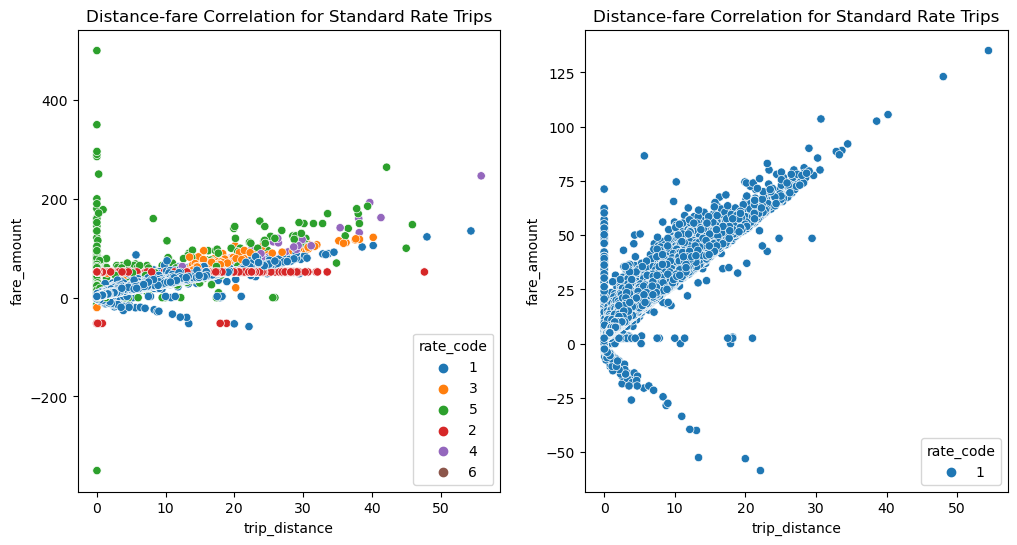

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x='trip_distance',y='fare_amount',data=df_pd,hue='rate_code',ax=ax[0])
ax[0].set_title("Distance-fare Correlation for Standard Rate Trips")
ax[0].legend(loc='lower right',title='rate_code')

sns.scatterplot(x='trip_distance',y='fare_amount',data=df_pd[df_pd['rate_code']=='1'],ax=ax[1],hue='rate_code')
ax[1].set_title("Distance-fare Correlation for Standard Rate Trips")
ax[1].legend(loc='lower right',title='rate_code')

plt.show()

We use the code below to fix the data:
* For all trips, we eliminate records that have a 0 or negative trip distance.
* For all trips, we eliminate records with a total_amount less than \$2.5.
* For standard rate trips, we eliminate records whose trip distance doesn't folllow a linear correlation with a slope of at least 2.5 with fare_amount.
* For non-standard-rate trips, because the correlation between trip distance and fare_amount largely depend on actual negotiation between customers and drivers, we will keep those data points where trip distance and fare_amount don't follow a linear correlation as discussed before.

In [26]:
df_standard_rate =df_raw.where((df_raw['rate_code']=='1')&(df_raw['trip_distance']>0)&(df_raw['total_amount']>=2.5)&(df_raw['fare_amount']/df_raw['trip_distance']>=2.5))
df_other_rates =df_raw.where((df_raw['rate_code']!='1')&(df_raw['trip_distance']>0)&(df_raw['total_amount']>=2.5))

Dataframe, df, created below is a clean version that has addressed all missing values, outliers, and abnormal records.

In [75]:
df = df_standard_rate.union(df_other_rates)

Below are plots that describe the correlation between trip distance and fare after outliers are eliminated.

In [74]:
import pandas as pd
df_pd = pd.concat([df_standard_rate_pd,df_other_rates_pd])

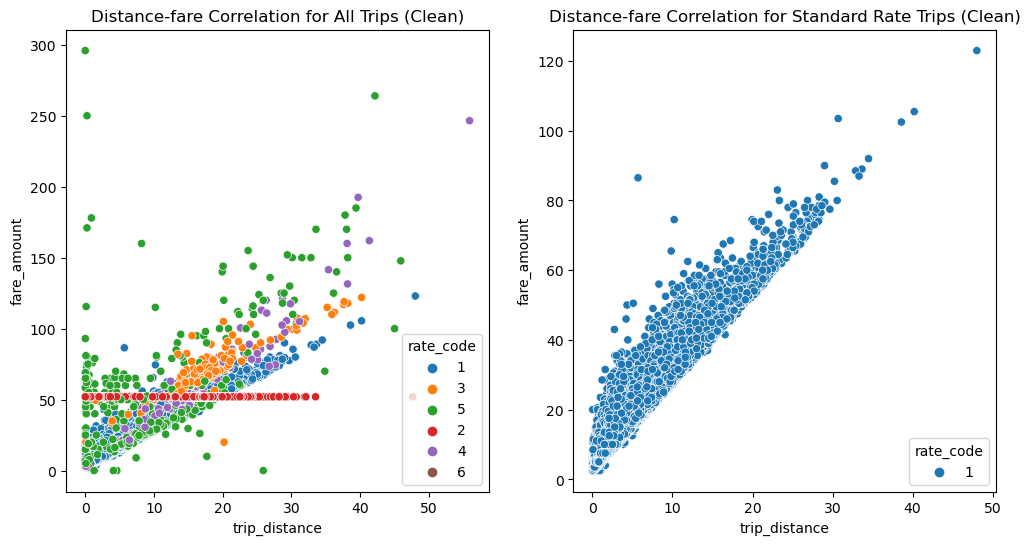

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x='trip_distance',y='fare_amount',data=df_pd,hue='rate_code',hue_order = ['1', '2','3','4','5','6'],ax=ax[0])
ax[0].set_title("Distance-fare Correlation for All Trips (Clean)")
ax[0].legend(loc='lower right',title='rate_code')

sns.scatterplot(x='trip_distance',y='fare_amount',data=df_pd[df_pd['rate_code']=='1'],ax=ax[1],hue='rate_code')
ax[1].set_title("Distance-fare Correlation for Standard Rate Trips (Clean)")
ax[1].legend(loc='lower right',title='rate_code')

plt.show()

The right-hand side plot suggests that the fare for JFK trips, represented by the red dots, are quite fixed no matter how long the trip actually covers. Trips other than JFK and negotiated-price trips mostly follow linear distribution between distance and fare. Negotiated-price trips seem to follow a more unusual distribution, which might depend on the actual negotiation between customers and drivers.

Here we also create the same plots for trip distance and total price (not the fare calculated merely from distance and time). The correlation reflected in the plots resemble the fare-counterpart a lot, because there're other fees, surcharges, tax, and tips involved.

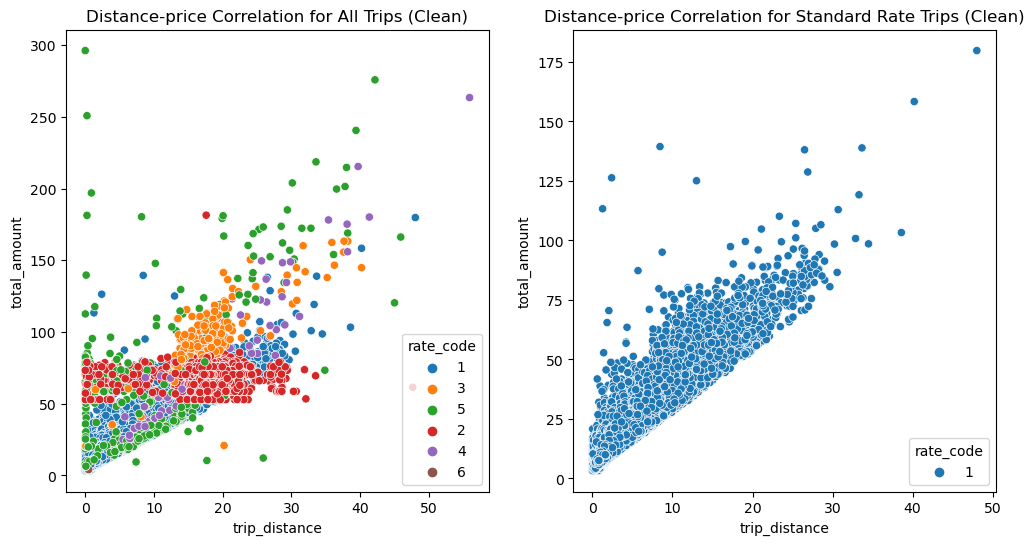

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x='trip_distance',y='total_amount',data=df_pd,hue='rate_code',ax=ax[0])
ax[0].set_title("Distance-price Correlation for All Trips (Clean)")
ax[0].legend(loc='lower right',title='rate_code')

sns.scatterplot(x='trip_distance',y='total_amount',data=df_pd[df_pd['rate_code']=='1'],ax=ax[1],hue='rate_code')
ax[1].set_title("Distance-price Correlation for Standard Rate Trips (Clean)")
ax[1].legend(loc='lower right',title='rate_code')

plt.show()

### **3.e. Feature Engineering**

In [36]:
from pyspark.sql.types import TimestampType

EDT_start = "2021-03-14"
EST_start = "2021-11-07"

In [39]:
from pyspark.sql.functions import from_utc_timestamp

Because pickup/dropoff time in the original dataset is indicated by UTC, we here convert UTC to Eastern Time

In [78]:
df = df.withColumn(
    "pickup_ET",
    from_utc_timestamp('pickup_datetime','America/New_York')
)

df = df.withColumn(
    "dropoff_ET",
    from_utc_timestamp('dropoff_datetime','America/New_York')
)

In [47]:
df.printSchema()

root
 |-- vendor_id: string (nullable = false)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: decimal(38,9) (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: decimal(38,9) (nullable = true)
 |-- extra: decimal(38,9) (nullable = true)
 |-- mta_tax: decimal(38,9) (nullable = true)
 |-- tip_amount: decimal(38,9) (nullable = true)
 |-- tolls_amount: decimal(38,9) (nullable = true)
 |-- imp_surcharge: decimal(38,9) (nullable = true)
 |-- airport_fee: decimal(38,9) (nullable = true)
 |-- total_amount: decimal(38,9) (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: double (nullable = true)
 |-- dropoff_ET: timestamp (nullable = true)
 |--

In [48]:
df.select('pickup_datetime','pickup_ET','dropoff_datetime','dropoff_ET').show(5)

+-------------------+-------------------+-------------------+-------------------+
|    pickup_datetime|          pickup_ET|   dropoff_datetime|         dropoff_ET|
+-------------------+-------------------+-------------------+-------------------+
|2021-01-01 00:43:30|2020-12-31 19:43:30|2021-01-01 01:11:06|2020-12-31 20:11:06|
|2021-01-01 00:15:48|2020-12-31 19:15:48|2021-01-01 00:31:01|2020-12-31 19:31:01|
|2021-01-01 00:19:57|2020-12-31 19:19:57|2021-01-01 00:43:03|2020-12-31 19:43:03|
|2021-01-01 00:44:58|2020-12-31 19:44:58|2021-01-01 01:07:41|2020-12-31 20:07:41|
|2021-01-01 00:06:11|2020-12-31 19:06:11|2021-01-01 00:23:40|2020-12-31 19:23:40|
+-------------------+-------------------+-------------------+-------------------+
only showing top 5 rows



Create a column "day_of_week" to indicate the day of week for analysis

In [79]:
from pyspark.sql.functions import date_format
df = df.withColumn('day_of_week', date_format('pickup_ET','EEEE'))

Extract the hour of the day for analysis

In [80]:
df = df.withColumn('hour', hour(df['pickup_ET']))

In [53]:
df.select('pickup_ET','hour').show(5)

+-------------------+----+
|          pickup_ET|hour|
+-------------------+----+
|2020-12-31 19:43:30|  19|
|2020-12-31 19:15:48|  19|
|2020-12-31 19:19:57|  19|
|2020-12-31 19:44:58|  19|
|2020-12-31 19:06:11|  19|
+-------------------+----+
only showing top 5 rows



In [54]:
df_raw.unpersist()

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string, year: int, duration: double, dropoff_ET: timestamp, pickup_ET: timestamp, day_of_week: string, hour: int]

In [81]:
df.cache()

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string, year: int, duration: double, pickup_ET: timestamp, dropoff_ET: timestamp, day_of_week: string, hour: int]

In [55]:
df.printSchema()

root
 |-- vendor_id: string (nullable = false)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: decimal(38,9) (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: decimal(38,9) (nullable = true)
 |-- extra: decimal(38,9) (nullable = true)
 |-- mta_tax: decimal(38,9) (nullable = true)
 |-- tip_amount: decimal(38,9) (nullable = true)
 |-- tolls_amount: decimal(38,9) (nullable = true)
 |-- imp_surcharge: decimal(38,9) (nullable = true)
 |-- airport_fee: decimal(38,9) (nullable = true)
 |-- total_amount: decimal(38,9) (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: double (nullable = true)
 |-- dropoff_ET: timestamp (nullable = true)
 |--

## **4. Summary Statistics**

The clean dataframe has rows and columns.

In [ ]:
print(df.count(),len(df.columns))

239441040 24


### 4.a. Distribution of duration, distance, and price
The distribution of three key columns are displayed below.
* The range of taxi trip durations is from 0.02 to 153 minutes with the average being 14 minutes. There's more concentration in short-duration according to the histgram.
* The range of taxi trip distance is from 0.01 to 167,329 miles with the average being 3 miles. Most data points fall under the lower range of the distance span. (Eliminating extreme values for trip distances takes too long, so it was not done due to time ristriction)
* The range of taxi trip prices is from \\$2.5 to \\$998,325 dollars with the average being \\$18. The majority of data points fall under the range of 2.5 to 30 dollars. (Eliminating extreme values for total price takes too long, so it was not done due to time ristriction)

In [76]:
print(df.select('duration').describe().show(),df.select('trip_distance').describe().show(),df.select('total_amount').describe().show())

+-------+------------------+
|summary|          duration|
+-------+------------------+
|  count|         236937680|
|   mean|14.202429541683667|
| stddev|11.379465486849186|
|    min|              0.02|
|    max|            185.52|
+-------+------------------+



+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|         236937680|
|   mean|   2.9694555070000|
| stddev|18.803850644132353|
|    min|       0.010000000|
|    max|  167329.450000000|
+-------+------------------+



+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|         236937680|
|   mean|  17.7396180310000|
| stddev|146.89305083547453|
|    min|       2.500000000|
|    max|  998325.610000000|
+-------+------------------+

None None None


The histograms below are based on a portion sampled from the whole dataframe for efficient visualization only. Further analysis will be done on the whole dataframe.

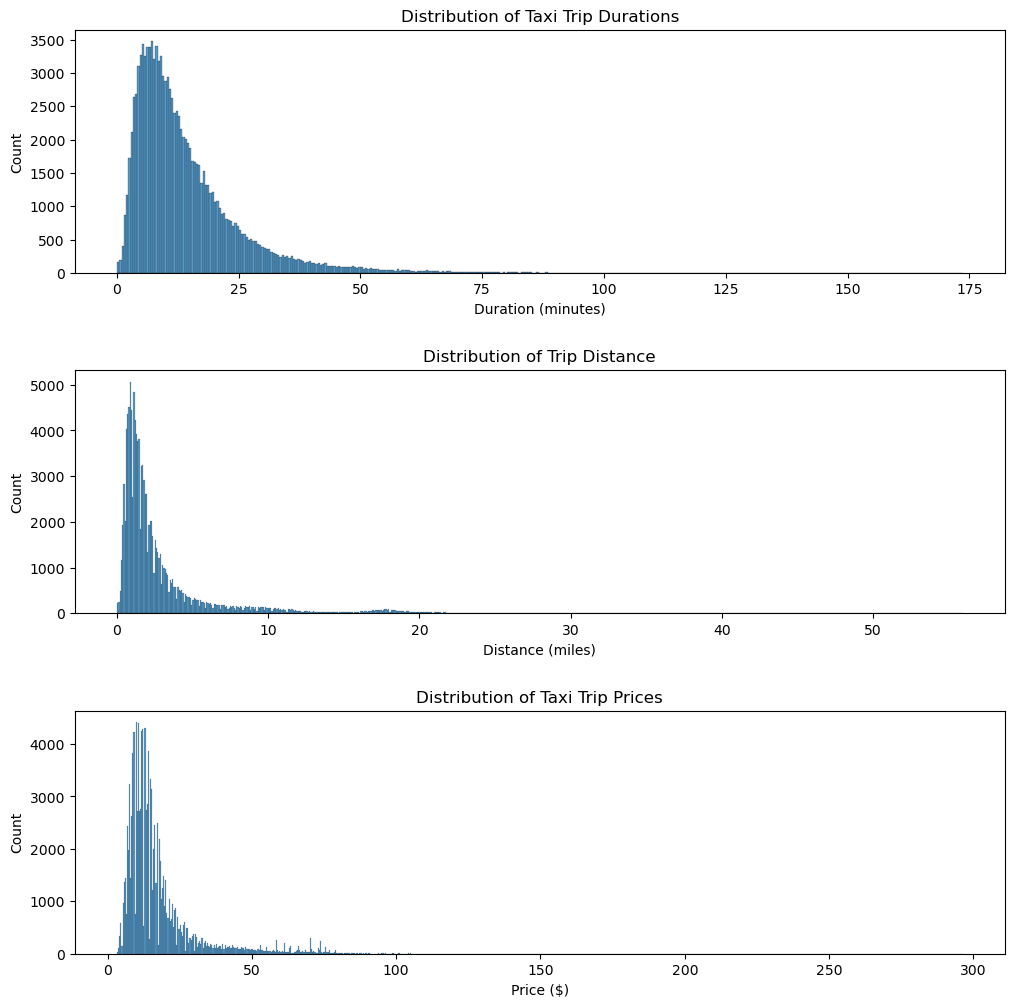

In [58]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

sns.histplot(df_pd['duration'], ax=ax[0])
ax[0].set_title('Distribution of Taxi Trip Durations')
ax[0].set_xlabel('Duration (minutes)')

sns.histplot(df_pd['trip_distance'], ax=ax[1])
ax[1].set_title('Distribution of Trip Distance')
ax[1].set_xlabel('Distance (miles)')

sns.histplot(df_pd['total_amount'], ax=ax[2])
ax[2].set_title('Distribution of Taxi Trip Prices')
ax[2].set_xlabel('Price ($)')

plt.subplots_adjust(hspace=0.4)
plt.show()

### 4.b. Taxi Trip Pricing
The code and graph below show the composition of a taxi trip price. We only include standard-rate trips to show the percentage of tips in total price, as our dataset only has the tip_amount column for trips paid with credit card.

In [82]:
from pyspark.sql.functions import mean, sum

avg_prices = df.where(col('payment_type')=='1').select(
    mean("fare_amount").alias("avg_fare"), 
    mean("tip_amount").alias("avg_tips"), 
    mean("extra").alias("avg_extra"),
    mean("mta_tax").alias("avg_tax"),
    mean("tolls_amount").alias("avg_tolls"),
    mean("imp_surcharge").alias("avg_surcharge")
)

In [83]:
avg_prices = avg_prices.withColumn('avg_total', col('avg_fare')+ col('avg_extra')+ col('avg_tips')+ col('avg_tax')+ col('avg_surcharge')+ col('avg_tolls'))
avg = avg_prices.first()

In [ ]:
fare_pctg = avg_prices.select(col('avg_fare')/col('avg_total')*100).collect()[0][0]
tips_pctg = avg_prices.select(col('avg_tips')/col('avg_total')*100).collect()[0][0]
extra_pctg = avg_prices.select(col('avg_extra')/col('avg_total')*100).collect()[0][0]
tax_pctg = avg_prices.select(col('avg_tax')/col('avg_total')*100).collect()[0][0]
tolls_pctg = avg_prices.select(col('avg_tolls')/col('avg_total')*100).collect()[0][0]
surcharge_pctg = avg_prices.select(col('avg_surcharge')/col('avg_total')*100).collect()[0][0]

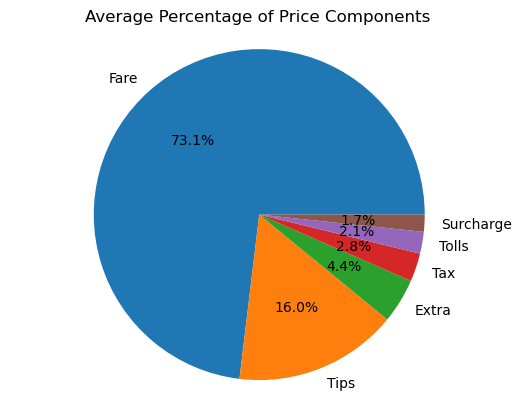

In [ ]:
import matplotlib.pyplot as plt
labels = ['Fare', 'Tips', 'Extra', 'Tax', 'Tolls', 'Surcharge']
sizes = [fare_pctg, tips_pctg, extra_pctg,  tax_pctg, tolls_pctg, surcharge_pctg]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Average Percentage of Price Components')
plt.show()

This pie chart indicates that the majority of taxi trip price comes from distance-and-time calculated fare, accounting for 73% of the total price. An average of 16% of total price is attributed to tips. Fees, tax, and surcharges account for the rest of total price.

In [71]:
df= spark.read.format("parquet").load("gs://is843-team6/notebooks/jupyter/df.parquet")

## **5. Exploratory Data Analysis**

### **5.a. Demand**
Revenue = Demand * Price <br>
According to the equation above, we want to start with looking at the demand patterns for NYC taxi trips.

#### **Question 1: How does the distribution of taxi demand differ across the days of the week, time of day, and month?**

##### **Taxi demand distribution across hours of a day in 2021**

In [ ]:
df.createOrReplaceTempView('df')

In [178]:
from pyspark.sql.functions import col
df_2021 = df.where((col('year')==2021)&(col('pickup_ET')!='2121-11-07')&(col('pickup_ET')!='2021-03-14'))

In [179]:
df_2021.createOrReplaceTempView('df_2021')

In [186]:
hourly_demand2021 = spark.sql("""
SELECT hour, COUNT(*) AS demand_hour
FROM df_2021
GROUP BY hour
ORDER BY hour
""")

hourly_demand2021_pd = hourly_demand2021.toPandas()

<Figure size 600x600 with 0 Axes>

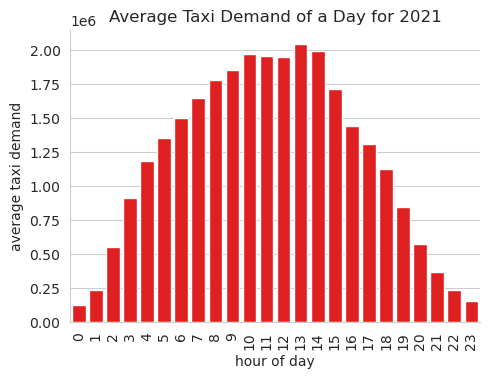

In [196]:
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
plot = sns.catplot(x='hour', y='demand_hour',data=hourly_demand2021_pd,kind='bar',color='red')
plot.set(xlabel='hour of day', ylabel='average taxi demand')
plt.title('Average Taxi Demand of a Day for 2021')
plot.set_xticklabels(rotation=90)
plt.subplots_adjust(top=0.7)
plt.show()

Rush hours are 10 am to 3 pm, when the demand for taxis is high. For drivers to optimize their income, avoiding rush hours that may see traffic congestion and midnight when taxi demand is too low would be a good strategy.

##### **Taxi demand distribution across days of the week**

In [ ]:
df_weekly_demand_pd = df_weekly_demand.toPandas()

<Figure size 800x600 with 0 Axes>

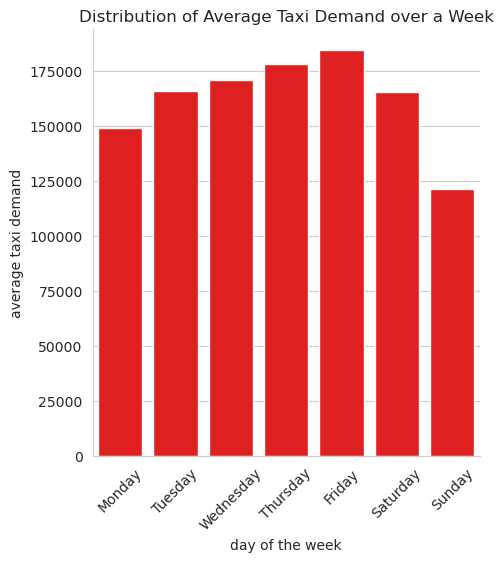

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
plot = sns.catplot(x='day_of_week', y='avg_demand',data=df_weekly_demand_pd,kind='bar',color='red',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plot.set(xlabel='day of the week', ylabel='average taxi demand')
plt.title('Distribution of Average Taxi Demand over a Week')
plot.set_xticklabels(rotation=45)
plt.show()


Based on the graph above, from 2018 to 2021, Sunday saw the lowest demand for taxi trips, while Friday saw the highest demand. If drivers want to make more money, they may not take business on these two days because Friday may see congestion, and you may only take a few customers on Sunday. 

##### **Hourly taxi demand distribution**

Count the number of taxi trips for each hour of a day

In [ ]:
hourly_distribution = df.groupBy("hour").count().orderBy("hour")
hourly_distribution.show(25)

+----+--------+
|hour|   count|
+----+--------+
|   0| 1851309|
|   1| 3128851|
|   2| 6334319|
|   3| 9349140|
|   4|10813174|
|   5|11137490|
|   6|11521145|
|   7|12229850|
|   8|12805310|
|   9|13202922|
|  10|13714879|
|  11|13308316|
|  12|13422739|
|  13|14877029|
|  14|15236563|
|  15|14033836|
|  16|12990995|
|  17|12459798|
|  18|10918785|
|  19| 8513946|
|  20| 5990693|
|  21| 4125097|
|  22| 2903280|
|  23| 2068214|
+----+--------+



##### **Monthly taxi demand distribution in 2019, 2020, and 2021**

In [ ]:
from pyspark.sql.functions import year, month, count, date_trunc
import seaborn as sns

df_filtered = df.filter((df['year'] == 2019) | 
                        (df['year'] == 2020) | 
                        (df['year'] == 2021))

In [ ]:
df_monthly_distribution = df_filtered.groupBy(("year"), 
                                              month("pickup_ET").alias("month")) \
                                     .count() \
                                     .orderBy("year", "month")

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


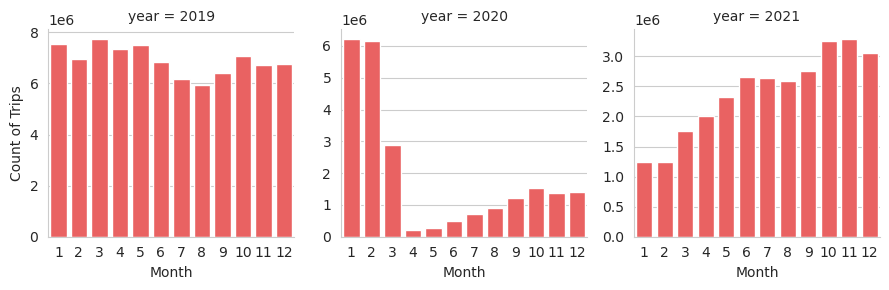

In [ ]:
 df_monthly_distribution_graph= sns.FacetGrid(df_monthly_distribution.toPandas(), col="year", col_wrap=3, sharey=False)
 df_monthly_distribution_graph.map(sns.barplot, "month", "count", palette=["#ff4c4c"])
 df_monthly_distribution_graph.set_axis_labels("Month", "Count of Trips")

Based on the graph above, it is evident that in 2019 most months had a similar distribution of trips, with winter months showing slightly higher amounts when compared to summer. January and February of 2020 displayed nearly identical results. However, there was a significant decrease in taxi trips starting in March due to the covid pandemic and stay-at-home mandates. Consequently, the entirety of 2020 displayed much lower numbers than the previous years. However, in 2021, with the distribution of the covid vaccine and the start of a return to normalcy, the number of trips shows an upward trend. 


### **Question 2: How does taxi demand differ across different time categories?**

In [95]:
# Dividing the Pickup time into 5 Categories:
''' 
* Late Night: This is the period between midnight and sunrise, usually from 12:00 AM to 5:59 AM.

* Morning: This is the period after sunrise and before noon, usually from 6:00 AM to 11:59 AM.

* Afternoon: This is the period between noon and evening, usually from 12:00 PM to 4:59 PM.

* Evening: This is the period between late afternoon and late night, usually from 5:00 PM to 8:59 PM.

* Night: This is the period between late evening and early morning, usually from 9:00 PM to 11:59 PM.'''

from pyspark.sql.functions import hour, when

# Categorizing the pickup_ET time in different time categories (5 in our case)
spark_df_changed_casted_dataframe_f = df.withColumn('pickup_time_category', \
                    when((df.hour >= 0) & (df.hour <= 5), 'Late Night') \
                    .when((df.hour >= 6) & (df.hour <= 11), 'Morning') \
                    .when((df.hour >= 12) & (df.hour <= 16), 'Afternoon') \
                    .when((df.hour >= 17) & (df.hour <= 20), 'Evening') \
                    .otherwise('Night'))

# Show the resulting dataframe
spark_df_changed_casted_dataframe_f.select('pickup_ET', 'pickup_time_category').show(5)


+-------------------+--------------------+
|          pickup_ET|pickup_time_category|
+-------------------+--------------------+
|2020-12-31 19:43:30|             Evening|
|2020-12-31 19:15:48|             Evening|
|2020-12-31 19:19:57|             Evening|
|2020-12-31 19:44:58|             Evening|
|2020-12-31 19:06:11|             Evening|
+-------------------+--------------------+
only showing top 5 rows



In [96]:
spark_df_changed_casted_dataframe_f.cache()

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string, year: int, duration: double, pickup_ET: timestamp, dropoff_ET: timestamp, day_of_week: string, hour: int, pickup_time_category: string]

In [97]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import count

# Calculating demand of number of rides through count by pickup time category
pickup_demand = spark_df_changed_casted_dataframe_f.groupBy('pickup_time_category').agg(count('*').alias('demand')).orderBy('demand', ascending=False)

# Displaying pickup demand in decreasing order
print("Pickup Demand:")
pickup_demand.show()



Pickup Demand:


+--------------------+--------+
|pickup_time_category|  demand|
+--------------------+--------+
|             Morning|76782422|
|           Afternoon|70561162|
|          Late Night|42614283|
|             Evening|37883222|
|               Night| 9096591|
+--------------------+--------+



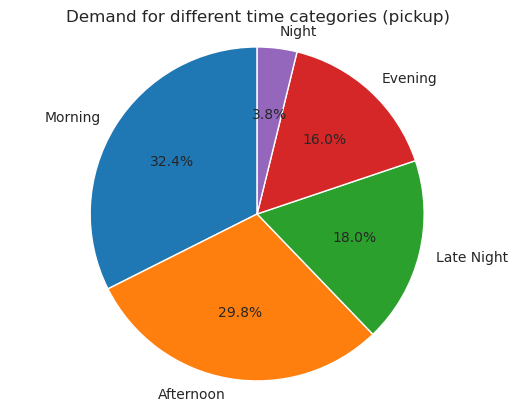

In [98]:
# Calculate demand of number of rides by pickup time category
pickup_demand = spark_df_changed_casted_dataframe_f.groupBy('pickup_time_category').agg(count('*').alias('demand')).orderBy('demand', ascending=False)

# Plot pie chart of demand by pickup time category
plt.pie(pickup_demand.select('demand').rdd.flatMap(lambda x: x).collect(), labels=pickup_demand.select('pickup_time_category').rdd.flatMap(lambda x: x).collect(), autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Demand for different time categories (pickup)')
plt.show()



* Most of the Taxis were taken in Morning and Afternoon Time 
* Least Taxis were taken at night from:  9:00 PM to 11:59 PM.


### **Question 3: What are the ten most frequently traveled routes for taxi rides in NYC?**
Building on our findings about demand for different times, we want to look into locations and routes that lead to high revenue.

In [200]:
B = spark.read.format("bigquery").option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom").load().select("zone_name", "zone_id")
A_with_zone = df.join(B, df.dropoff_location_id == B.zone_id, how="left").withColumn("dropoff_zone_name", B.zone_name)\
                .drop("zone_id", "zone_name").join(B, df.pickup_location_id == B.zone_id, how="left").withColumn("pickup_zone_name", B.zone_name).drop("zone_id", "zone_name")


In [100]:
A_with_zone.show(5)

23/04/30 23:19:26 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----------+-----------+-----------+------------+-------------+--------------+------------+------------------+-------------------+----+--------+-------------------+-------------------+-----------+----+--------------------+-----------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type| fare_amount|      extra|    mta_tax| tip_amount|tolls_amount|imp_surcharge|   airport_fee|total_amount|pickup_location_id|dropoff_location_id|year|duration|          pickup_ET|         dropoff_ET|day_of_week|hour|   dropoff_zone_name| pickup_zone_name|
+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+------------+-----------+-----------+-----------+------------+-------------+--------------+------------+------------------+

In [103]:
from pyspark.sql.functions import count, avg, expr
from pyspark.sql.window import Window

df_zone = A_with_zone.select("pickup_zone_name", "dropoff_zone_name", "fare_amount", "pickup_datetime", "dropoff_datetime", "trip_distance") \
       .filter((A_with_zone.pickup_zone_name.isNotNull()) & (A_with_zone.dropoff_zone_name.isNotNull()) & (A_with_zone.fare_amount.isNotNull()) & (A_with_zone.pickup_datetime.isNotNull()) & (A_with_zone.dropoff_datetime.isNotNull()) & (A_with_zone.trip_distance.isNotNull()))
#new column 
df_zone = df_zone.withColumn("duration_minutes", expr("(UNIX_TIMESTAMP(dropoff_datetime) - UNIX_TIMESTAMP(pickup_datetime))/60"))
#groupby
df_zone = df_zone.groupBy("pickup_zone_name", "dropoff_zone_name") \
       .agg(count("*").alias("trip_count"),
            avg("fare_amount").alias("avg_fare_amount"),
            avg("duration_minutes").alias("avg_duration_minutes"),
            avg("trip_distance").alias("avg_trip_distance")) \
       .orderBy("trip_count", ascending=False) \
       .limit(10)

df_zone.show()


+--------------------+--------------------+----------+---------------+--------------------+-----------------+
|    pickup_zone_name|   dropoff_zone_name|trip_count|avg_fare_amount|avg_duration_minutes|avg_trip_distance|
+--------------------+--------------------+----------+---------------+--------------------+-----------------+
|Upper East Side S...|Upper East Side N...|   1536223|6.4637527170000|   6.567530657983904|  1.0572492410000|
|Upper East Side N...|Upper East Side S...|   1301958|7.0365252410000|   7.903893942815366|  1.0562288340000|
|Upper East Side N...|Upper East Side N...|   1230563|5.1022814760000|   4.508901779104363|  0.6337434900000|
|Upper East Side S...|Upper East Side S...|   1166238|5.4694903610000|   5.212215145336262|  0.6620207370000|
|Upper West Side S...|Upper West Side N...|    687418|5.4631325630000|    4.91102594539761|  0.8376672270000|
|Upper West Side S...| Lincoln Square East|    667270|5.8577696130000|   5.711464999175746|  0.8722473960000|
| Lincoln 

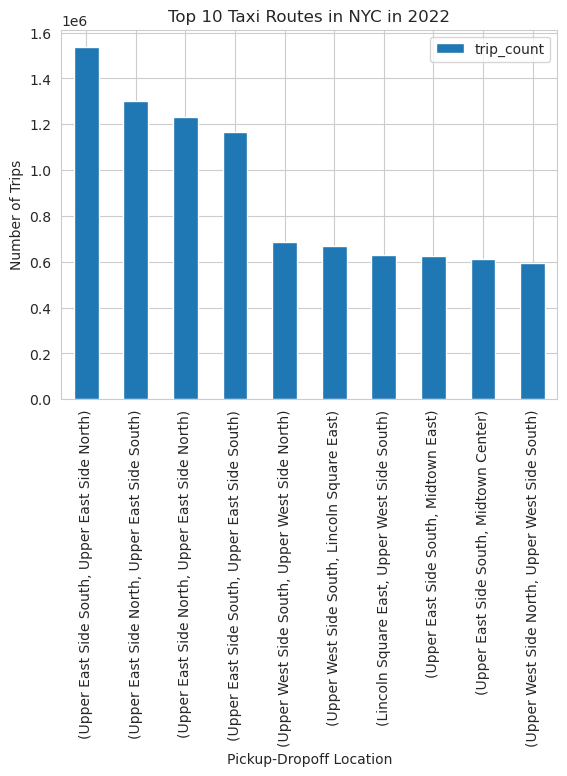

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
pandas_df = df_zone.toPandas()
pandas_df = pandas_df.set_index(["pickup_zone_name", "dropoff_zone_name"])
pandas_df.plot(kind="bar", y="trip_count")
plt.title("Top 10 Taxi Routes in NYC in 2022")
plt.xlabel("Pickup-Dropoff Location")
plt.ylabel("Number of Trips")
plt.show()


### **5.b. Revenue**
After identifying times and locations that have high taxi demand, we are switching gears to see what factors contribute to higher revenue.

#### **Question 4(a): Which trip category produces the highest revenue: short-distance, medium-distance, or long-distance?**


In this subsection of our Exploratory Data Analysis, we examined what types of trips lead to the highest revenue. 


In [105]:
from pyspark.sql.functions import month, round, avg

# Calculate revenue per trip for each month
revenue_per_month_df = df.groupBy(month("pickup_datetime").alias("month")).agg(avg("fare_amount")).withColumnRenamed("avg(fare_amount)", "revenue_per_trip")

# Calculate number of trips in each month
# trips_per_month_df = df_raw.groupBy(month("pickup_datetime").alias("month")).count().withColumnRenamed("count", "num_trips")

# Calculate revenue per trip and number of trips for each month
# revenue_and_trips_per_month_df = revenue_per_month_df.join(trips_per_month_df, "month").withColumn("revenue_per_trip_per_month", round(col("revenue_per_trip") / col("num_trips"), 2))

# Sort results by month
revenue_and_trips_per_month_df = revenue_per_month_df.orderBy("month")

# Show results
revenue_and_trips_per_month_df.show()


+-----+----------------+
|month|revenue_per_trip|
+-----+----------------+
|    1|12.1986250570000|
|    2|12.3261965430000|
|    3|12.6058248030000|
|    4|12.8352320990000|
|    5|13.1640045580000|
|    6|13.2056539470000|
|    7|13.1338113010000|
|    8|13.2188672570000|
|    9|13.3761508200000|
|   10|13.2840054000000|
|   11|13.1711842640000|
|   12|13.1354568650000|
+-----+----------------+



#### **Question 4(b): How much each type of trip (long, short, medium)  makes per minute of trip?**

Cost was calulated based on minute because it was thoght that in some location or some time short trips may take same time as long trip, and sometimes long trip may take too much time, so considering per minute makes the cost more easier to compare with different types of trip rather than comparing with the distance.

So from the below code we can see that overall long trip cost more per minute, then shorter one cost more and then medium one cost the least.

In [91]:


from pyspark.sql.functions import col, round, when, month, from_unixtime, unix_timestamp, round, avg, sort_array

# Calculate trip distance bucket and pickup hour
df_with_distance_bucket = df.withColumn("trip_distance_bucket", when(col("trip_distance") < 3, "short").when((col("trip_distance") >= 3) & (col("trip_distance") < 6), "medium").otherwise("long"))
df_with_pickup_hour = df_with_distance_bucket.withColumn("pickup_hour", from_unixtime(unix_timestamp(col("pickup_datetime")), "H"))

# Calculate duration of trip in minutes
df_with_duration = df_with_pickup_hour.withColumn("duration", (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60)

# Calculate revenue per minute of trip for each trip distance bucket and pickup hour
revenue_per_minute_df = df_with_duration.groupBy("trip_distance_bucket", "pickup_hour").agg(avg("fare_amount") / avg("duration")).withColumnRenamed("(avg(fare_amount) / avg(duration))", "revenue_per_minute")

revenue_per_minute_df = revenue_per_minute_df.orderBy(col("pickup_hour"))

pivot_table = revenue_per_minute_df.groupBy("pickup_hour")\
                      .pivot("trip_distance_bucket", ["short", "medium", "long"])\
                      .agg(round(avg("revenue_per_minute"), 2))\
                      .select("pickup_hour", "short", "medium", "long")\
                      .orderBy(col("pickup_hour"))


pivot_table.show(24)


+-----------+-----+------+----+
|pickup_hour|short|medium|long|
+-----------+-----+------+----+
|          0| 0.98|  0.92|1.28|
|          1| 1.04|  0.96|1.29|
|         10| 0.83|   0.8|1.08|
|         11| 0.81|  0.79|1.08|
|         12| 0.81|  0.79|1.09|
|         13| 0.81|   0.8|1.05|
|         14| 0.81|  0.77|0.96|
|         15| 0.81|  0.76| 0.9|
|         16| 0.82|  0.76|0.89|
|         17| 0.82|  0.76|0.91|
|         18| 0.83|  0.78|1.01|
|         19| 0.86|  0.81|1.11|
|          2| 1.05|   1.0|1.26|
|         20| 0.88|  0.84|1.18|
|         21|  0.9|  0.86|1.19|
|         22| 0.91|  0.87| 1.2|
|         23| 0.94|  0.89|1.23|
|          3| 1.07|  1.02| 1.3|
|          4| 1.15|  1.06|1.43|
|          5| 1.33|  1.09| 1.5|
|          6| 1.08|  1.01|1.26|
|          7| 0.93|  0.88|1.07|
|          8| 0.84|  0.81|1.02|
|          9| 0.81|   0.8|1.06|
+-----------+-----+------+----+



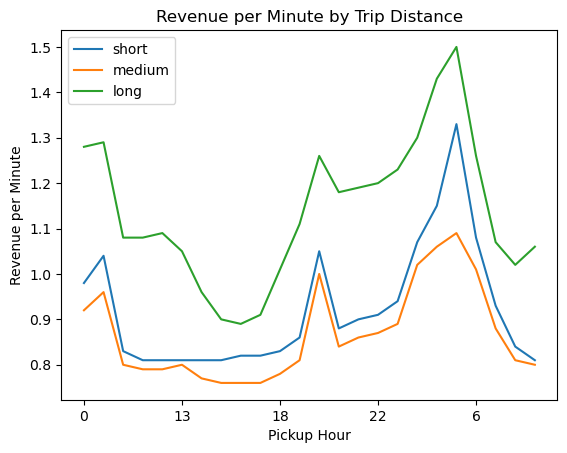

In [92]:
#graph to see the cost per minute for long, short, medium trip

import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = pivot_table.toPandas()

# Set the index to pickup_hour
pandas_df.set_index('pickup_hour', inplace=True)

# Plot the line chart
pandas_df.plot.line()

# Set the labels for the x and y axes
plt.xlabel('Pickup Hour')
plt.ylabel('Revenue per Minute')

# Set the title for the chart
plt.title('Revenue per Minute by Trip Distance')

# Show the chart
plt.show()


#### **Question 5: When do the most costly or least expensive trips usually take place?**

We also analyzed the cost of trips based on time of day, day of the week and month. 

##### **Cost of Trips Based on Time of Day**

In [107]:
from pyspark.sql.functions import hour, col

hourly_avg_fare = df.groupBy(hour("pickup_datetime").alias("pickup_hour")).avg("fare_amount")


In [108]:
most_costly_hours = hourly_avg_fare.orderBy(col("avg(fare_amount)").desc())
most_costly_hours.show(12)

+-----------+----------------+
|pickup_hour|avg(fare_amount)|
+-----------+----------------+
|          5|16.5496947010000|
|          4|15.1665596820000|
|         16|13.7225114830000|
|          0|13.5548416160000|
|         23|13.5405844990000|
|         15|13.5048257380000|
|         14|13.4591031480000|
|         17|13.2227479380000|
|          6|13.1736325640000|
|         22|13.1476809780000|
|         13|13.0749049110000|
|          1|12.9630381250000|
+-----------+----------------+
only showing top 12 rows



The table above indicates that the hours with the lowest average fare amounts are generally in the late night (4-6am), and during the afternoon (1-4pm).

In [109]:
least_costly_hours = hourly_avg_fare.orderBy(col("avg(fare_amount)").asc())
least_costly_hours.show(12)

+-----------+----------------+
|pickup_hour|avg(fare_amount)|
+-----------+----------------+
|         19|12.2015580750000|
|          7|12.2539309220000|
|          8|12.2789897940000|
|          2|12.3477758000000|
|          9|12.3588731210000|
|         18|12.5260646320000|
|         11|12.5427978560000|
|         10|12.5480344350000|
|         20|12.5684936080000|
|         12|12.7564840840000|
|          3|12.8283908540000|
|         21|12.8956748400000|
+-----------+----------------+
only showing top 12 rows



The table above indicates that the hours with the highest average fare amounts are generally in the evening and late night. However, the prices are fairly consistent. 

##### **Cost of Trips Based on Day of the Week**

In [111]:
from pyspark.sql.functions import dayofweek, col

dayofweek_avg_fare = df.groupBy(dayofweek("pickup_datetime").alias("pickup_dow")).avg("fare_amount")

In [112]:
most_costly_days = dayofweek_avg_fare.orderBy(col("avg(fare_amount)").desc())
most_costly_days.show(7)


+----------+----------------+
|pickup_dow|avg(fare_amount)|
+----------+----------------+
|         5|13.2198030620000|
|         1|13.1577534700000|
|         6|13.0683533850000|
|         2|13.0171181340000|
|         4|12.9279615040000|
|         3|12.7937460980000|
|         7|12.4044454370000|
+----------+----------------+



##### **Cost of Trips Based on Month**

In [113]:
from pyspark.sql.functions import month, avg

cost_by_month = df.groupBy(month("pickup_datetime").alias("pickup_month")).agg(avg("fare_amount").alias("avg_fare")).orderBy("pickup_month")
cost_by_month.show()


+------------+----------------+
|pickup_month|        avg_fare|
+------------+----------------+
|           1|12.1986250570000|
|           2|12.3261965430000|
|           3|12.6058248030000|
|           4|12.8352320990000|
|           5|13.1640045580000|
|           6|13.2056539470000|
|           7|13.1338113010000|
|           8|13.2188672570000|
|           9|13.3761508200000|
|          10|13.2840054000000|
|          11|13.1711842640000|
|          12|13.1354568650000|
+------------+----------------+



#### **Question 6: What proportion of all taxi trips are airport taxi trips, and what percentage of revenue do these trips generate?**

In [135]:
from pyspark.sql.functions import lower

taxi_zone_geom = spark.read.format("bigquery").option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom").load()

taxi_zone_geom = taxi_zone_geom.filter(lower(col("zone_name")).like("%airport%")).withColumn("zone_id_int", taxi_zone_geom["zone_id"].cast("int")).orderBy("zone_id_int")

taxi_zone_geom.show()

+-------+-----------------+-------+--------------------+-----------+
|zone_id|        zone_name|borough|           zone_geom|zone_id_int|
+-------+-----------------+-------+--------------------+-----------+
|      1|   Newark Airport|    EWR|POLYGON((-74.1856...|          1|
|    132|      JFK Airport| Queens|MULTIPOLYGON(((-7...|        132|
|    138|LaGuardia Airport| Queens|MULTIPOLYGON(((-7...|        138|
+-------+-----------------+-------+--------------------+-----------+



In [115]:
!pip install folium

In [136]:
import folium
from shapely import wkt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
taxi_zone_geom_pd = taxi_zone_geom.toPandas()

# Create a map centered on New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Extract the coordinates for each airport zone and add them as polygons to the map
for _, row in taxi_zone_geom_pd.iterrows():
    zone_geom = wkt.loads(row["zone_geom"])
    
    if zone_geom.geom_type == 'Polygon':
        polygons = [zone_geom]
    elif zone_geom.geom_type == 'MultiPolygon':
        polygons = list(zone_geom)

    for polygon in polygons:
        coordinates = []
        for point in polygon.exterior.coords:
            coordinates.append((point[1], point[0]))

        folium.Polygon(
            locations=coordinates,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.2,
            tooltip=row['zone_name']
        ).add_to(nyc_map)

# Display the map
nyc_map


/tmp/ipykernel_13493/394209981.py:18: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  polygons = list(zone_geom)
/tmp/ipykernel_13493/394209981.py:18: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygons = list(zone_geom)


In [ ]:
#B = spark.read.format("bigquery").option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom").load()

#### **Question 7(a): Which pickup or dropoff locations generate the highest revenue?**

In [152]:
from pyspark.sql.functions import sum

# Read the taxi data into a DataFrame
taxi_data = df

# Group the data by pickup and dropoff location and sum the total revenue for each group
revenue_by_location = taxi_data.groupBy("pickup_location_id", "dropoff_location_id").agg(sum("total_amount").alias("total_revenue"))

# Join the location IDs with their corresponding names from the taxi zone geometry table
pickup_locations = spark.read.format("bigquery").option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom").load()
pickup_locations = pickup_locations.selectExpr("zone_id AS PULocationID", "zone_name AS pickup_name", "zone_geom AS pickup_zone_geom")

dropoff_locations = spark.read.format("bigquery").option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom").load()
dropoff_locations = dropoff_locations.selectExpr("zone_id AS DOLocationID", "zone_name AS dropoff_name", "zone_geom AS dropoff_zone_geom")

revenue_by_location = revenue_by_location.join(pickup_locations, revenue_by_location.pickup_location_id == pickup_locations.PULocationID)\
                                         .join(dropoff_locations, revenue_by_location.dropoff_location_id == dropoff_locations.DOLocationID)\
                                         .drop("pickup_location_id", "dropoff_location_id")

# Show the top 10 locations by total revenue
revenue_by_location.orderBy("total_revenue", ascending=False).show(10)

+------------------+------------+--------------------+--------------------+------------+--------------------+--------------------+
|     total_revenue|PULocationID|         pickup_name|    pickup_zone_geom|DOLocationID|        dropoff_name|   dropoff_zone_geom|
+------------------+------------+--------------------+--------------------+------------+--------------------+--------------------+
|17419717.680000000|         138|   LaGuardia Airport|MULTIPOLYGON(((-7...|         230|Times Sq/Theatre ...|POLYGON((-73.9831...|
|17172582.880000000|         132|         JFK Airport|MULTIPOLYGON(((-7...|         230|Times Sq/Theatre ...|POLYGON((-73.9831...|
|15734735.880000000|         237|Upper East Side S...|POLYGON((-73.9656...|         236|Upper East Side N...|POLYGON((-73.9572...|
|14132190.440000000|         236|Upper East Side N...|POLYGON((-73.9572...|         237|Upper East Side S...|POLYGON((-73.9656...|
|11946245.300000000|         138|   LaGuardia Airport|MULTIPOLYGON(((-7...|        

In [154]:
import folium
import shapely.wkt
import geopandas as gpd

#Show the top 10 locations
top_10_revenue_locations = revenue_by_location.orderBy("total_revenue", ascending=False).head(10)

#Initialize the map 
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Function to create a GeoJSON object for a polygon
def create_geojson_polygon(polygon_wkt):
    polygon = shapely.wkt.loads(polygon_wkt)
    return folium.GeoJson(gpd.GeoSeries(polygon).__geo_interface__)

#Plot the top 10 locations on the map
for row in top_10_revenue_locations:
    #Add the pickup
    pickup_geojson = create_geojson_polygon(row["pickup_zone_geom"])
    pickup_popup = f"Pickup: {row['pickup_name']} (Revenue: ${row['total_revenue']:.2f})"
    pickup_geojson.add_child(folium.Popup(pickup_popup)).add_to(nyc_map)

    #Add the dropoff
    dropoff_geojson = create_geojson_polygon(row["dropoff_zone_geom"])
    dropoff_popup = f"Dropoff: {row['dropoff_name']} (Revenue: ${row['total_revenue']:.2f})"
    dropoff_geojson.add_child(folium.Popup(dropoff_popup)).add_to(nyc_map)

#Display 
nyc_map

#### Question 7(b): Which Location cost the most per mile each hour of the day in different months? 
Below code is to find the cost during a particular hour of the month, which location cost the most. The reason for creating def function for it was because we speculated that some months might see different expensive location on different hours. so whichever month we are interested in we may can put in and get the result. For example,  month March and month December shows different location for different hours. In March, location which cost the most per mile per hour at 1 am was near 'Time Square'. For December the place cost most per mile per hour at 1 am was 'Boerum Hill'. So 2 months had different location whihc generated the most cost per mile at the same time of day 

In [93]:
#writing a function so that we get best location for different month
from pyspark.sql.functions import year, month, to_date

def get_best_location_by_hour(df, pickup_month):
    # Convert the pickup datetime column to a date
    df = df.withColumn("pickup_date", to_date(df.pickup_datetime))
    
    # Filter by pickup year and month
    filtered_df = df.filter((month(df.pickup_date) == pickup_month))
    
    # Group by pickup location and hour
    location_hour_df = filtered_df.groupBy("pickup_location_id", "hour").agg(
        {"fare_amount": "sum", "trip_distance": "sum", "passenger_count": "sum", "pickup_datetime": "count"}
    ).withColumnRenamed("sum(fare_amount)", "fare_amount").withColumnRenamed("sum(trip_distance)", "trip_distance") \
     .withColumnRenamed("sum(passenger_count)", "passenger_count") \
     .withColumnRenamed("count(pickup_datetime)", "num_trips")

    # Calculate revenue per trip and per mile
    revenue_per_trip_df = location_hour_df.withColumn("revenue_per_trip", location_hour_df.fare_amount / location_hour_df.num_trips)
    revenue_per_mile_df = location_hour_df.withColumn("revenue_per_mile", location_hour_df.fare_amount / location_hour_df.trip_distance)

    # Find the location with the highest revenue per mile for each hour
    best_location_by_hour_df = revenue_per_trip_df.join(revenue_per_mile_df, on=["pickup_location_id", "hour"]) \
        .groupBy("hour").agg(
        {"revenue_per_trip": "avg", "pickup_location_id": "first", "revenue_per_mile": "avg"}
    ).orderBy("hour")
    
    

    return best_location_by_hour_df

#     return best_location_by_hour_df




In [94]:
#Best location in March

best_loc_in_x_month = get_best_location_by_hour(df, 3)
B = spark.read.format("bigquery").option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom").load().select("zone_name", "zone_id")
A_with_zone = best_loc_in_x_month.join(B, (best_loc_in_x_month['first(pickup_location_id)'] == B.zone_id), how="left").withColumn("pickup_zone_name", B.zone_name).drop("zone_id", "zone_name")

A_with_zone.orderBy("hour").show(24)

+----+---------------------+---------------------+-------------------------+--------------------+
|hour|avg(revenue_per_mile)|avg(revenue_per_trip)|first(pickup_location_id)|    pickup_zone_name|
+----+---------------------+---------------------+-------------------------+--------------------+
|   0|         3.6071360000|     22.0128615650000|                       73|       East Flushing|
|   1|         3.7167900000|     25.1772937010000|                      230|Times Sq/Theatre ...|
|   2|         3.7376970000|     26.9930079920000|                       13|   Battery Park City|
|   3|         3.9939360000|     27.2469502200000|                      113|Greenwich Village...|
|   4|         4.1392920000|     24.2483896790000|                      152|      Manhattanville|
|   5|         4.1292230000|     22.9201988920000|                      224|Stuy Town/Peter C...|
|   6|         4.0952650000|     23.5621748130000|                      174|             Norwood|
|   7|         4.079

In [95]:
#Best Location in December
best_loc_in_x_month = get_best_location_by_hour(df, 12)
B = spark.read.format("bigquery").option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom").load().select("zone_name", "zone_id")
A_with_zone = best_loc_in_x_month.join(B, (best_loc_in_x_month['first(pickup_location_id)'] == B.zone_id), how="left").withColumn("pickup_zone_name", B.zone_name).drop("zone_id", "zone_name")

A_with_zone.orderBy("hour").show(24)

+----+---------------------+---------------------+-------------------------+--------------------+
|hour|avg(revenue_per_mile)|avg(revenue_per_trip)|first(pickup_location_id)|    pickup_zone_name|
+----+---------------------+---------------------+-------------------------+--------------------+
|   0|         4.4413530000|     26.3011313740000|                      209|             Seaport|
|   1|         3.8153360000|     27.5981832150000|                       25|         Boerum Hill|
|   2|         4.0594810000|     26.6663061000000|                       13|   Battery Park City|
|   3|         4.0988370000|     24.9411265850000|                      135|   Kew Gardens Hills|
|   4|         4.1116680000|     24.7182936980000|                      113|Greenwich Village...|
|   5|         4.1597260000|     23.8086866720000|                       89|Flatbush/Ditmas Park|
|   6|         4.1781250000|     24.8906365660000|                       75|   East Harlem South|
|   7|         4.156

### **Question 8: What and where do people give the highest percentage of tips?**
As tips account for 16% of the total price for taxi trips on average, we checked if there's a time in a day when people usually tip more generously. Also, we identified pickup and dropoff locations where customers are willing to give higher percentage of tips.

In [201]:
from pyspark.sql.functions import round
A_with_zone = A_with_zone.withColumn('tip_percentage',round(A_with_zone['tip_amount']/A_with_zone['total_amount']*100,2))

In [202]:
df_credit = A_with_zone.where(col('payment_type')=='1')

In [203]:
df_tip_mean = df_credit.groupBy('hour').agg({'tip_percentage':"mean"}).orderBy('hour')

In [204]:
pd_df_tip_mean = df_tip_mean.toPandas()

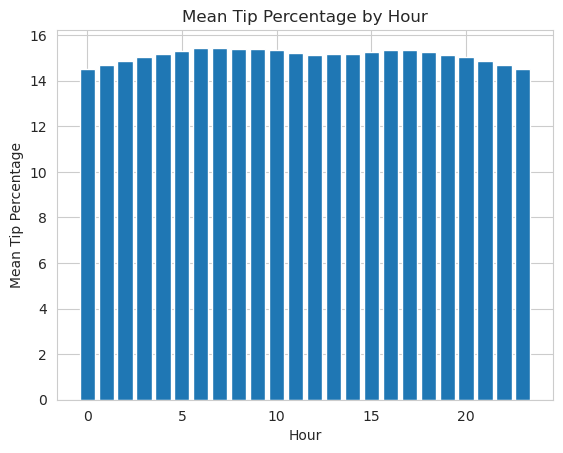

In [125]:
plt.bar(pd_df_tip_mean['hour'], pd_df_tip_mean['avg(tip_percentage)'])
plt.title('Mean Tip Percentage by Hour')
plt.xlabel('Hour')
plt.ylabel('Mean Tip Percentage')
plt.show()

In [205]:
from pyspark.sql.functions import desc
loc_tip_mean = df_credit.groupBy('pickup_zone_name').agg({'tip_percentage':"mean"}).orderBy(desc('avg(tip_percentage)'))

In [206]:
pd_loc_tip_mean = loc_tip_mean.toPandas()

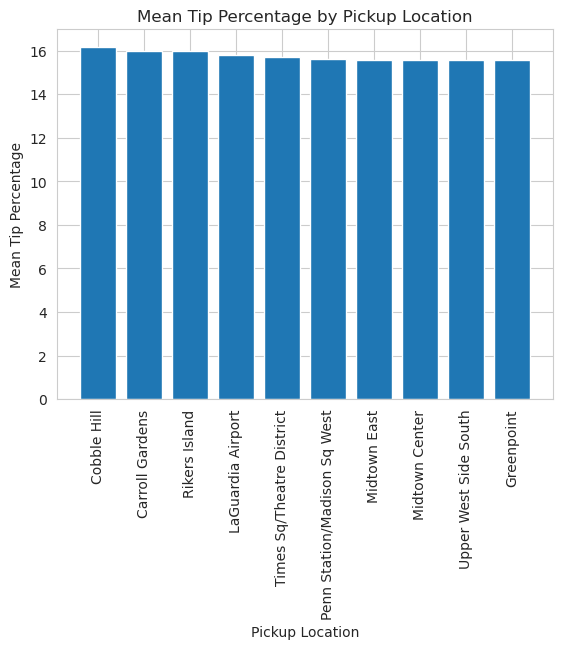

In [207]:
pd_loc_tip_mean['avg(tip_percentage)'] = pd_loc_tip_mean['avg(tip_percentage)'].astype('float')

top_10 = pd_loc_tip_mean.nlargest(10, 'avg(tip_percentage)')

plt.bar(top_10['pickup_zone_name'], top_10['avg(tip_percentage)'])
plt.title('Mean Tip Percentage by Pickup Location')
plt.xlabel('Pickup Location')
plt.xticks(rotation=90)
plt.ylabel('Mean Tip Percentage')
plt.show()

In [132]:
loc_dropoff_tip_mean = df_credit.groupBy('dropoff_zone_name').agg({'tip_percentage':"mean"}).orderBy(desc('avg(tip_percentage)'))

In [133]:
pd_loc_dropoff_tip_mean = loc_dropoff_tip_mean.toPandas()

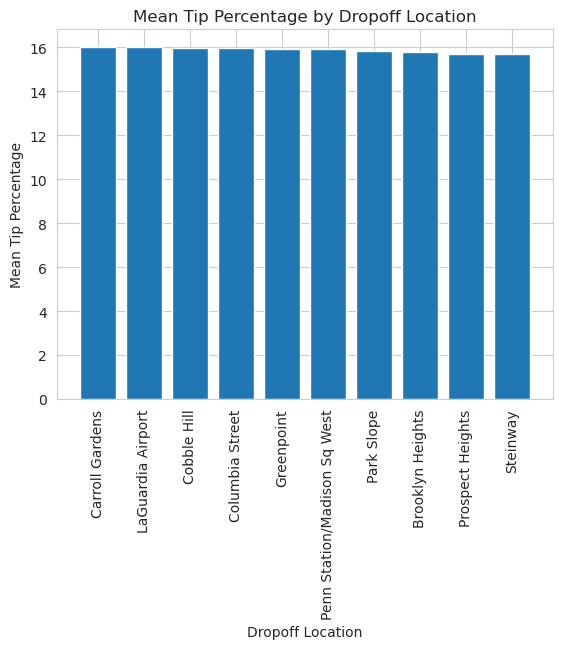

In [134]:
pd_loc_dropoff_tip_mean['avg(tip_percentage)'] = pd_loc_dropoff_tip_mean['avg(tip_percentage)'].astype('float')

top_10 = pd_loc_dropoff_tip_mean.nlargest(10, 'avg(tip_percentage)')

plt.bar(top_10['dropoff_zone_name'], top_10['avg(tip_percentage)'])
plt.title('Mean Tip Percentage by Dropoff Location')
plt.xlabel('Dropoff Location')
plt.xticks(rotation=90)
plt.ylabel('Mean Tip Percentage')
plt.show()

Based on the two graphs above, we conclude that Carroll Gardens, LaGuardia Airport, and Cobble Hill are the three locations (no matter whether pickup or dropoff location) where people tend to pay the highest percentage of tips. To motivate drivers and help them generate more revenue, these three locations would be recommended for drivers to pick up customers.

In [131]:
# Saving the parquet File code to avoid running eda cells for ML part: 
# df.write.format("parquet")\
# .option("header", "True")\
# .mode("overwrite")\
# .save("gs://is843-team6/notebooks/jupyter/df.parquet")

## **6. Machine Learning for Taxi Price Prediction**

#### **6.a. Required Data-Preprocessing :**

In [38]:
spark_df = spark.read.format("parquet").load("gs://is843-team6/notebooks/jupyter/df_sample.parquet")

In [41]:
spark_df_changed_casted_dataframe_f = spark_df.sample(False,fraction = .0005,  seed =843) # randomly selecting a sample from the spark_df DataFrame to perform Ml on. 

In [42]:
# Assuming df_sample as a dataframe to start/if you don't have it assign one
spark_df_changed_casted_dataframe_f # name of the dataframe

DataFrame[vendor_id: string, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: decimal(38,9), rate_code: string, store_and_fwd_flag: string, payment_type: string, fare_amount: decimal(38,9), extra: decimal(38,9), mta_tax: decimal(38,9), tip_amount: decimal(38,9), tolls_amount: decimal(38,9), imp_surcharge: decimal(38,9), airport_fee: decimal(38,9), total_amount: decimal(38,9), pickup_location_id: string, dropoff_location_id: string, year: int, duration: double, speed: double, pickup_ET: timestamp, dropoff_ET: timestamp, day_of_week: string, hour: int]

In [43]:
# Required DataFrame Casting
from pyspark.sql.functions import col
spark_df_changed_casted_dataframe_f = spark_df_changed_casted_dataframe_f.withColumn("rate_code", col("rate_code").cast("int")) \
              .withColumn("extra", col("extra").cast("double")) \
              .withColumn("mta_tax", col("mta_tax").cast("double")) \
              .withColumn("tip_amount", col("tip_amount").cast("double")) \
              .withColumn("tolls_amount", col("tolls_amount").cast("double")) \
              .withColumn("imp_surcharge", col("imp_surcharge").cast("double")) \
              .withColumn("airport_fee", col("airport_fee").cast("double")) \
              .withColumn("total_amount", col("total_amount").cast("double")) \
              .withColumn("passenger_count", col("passenger_count").cast("int")) \
              .withColumn("trip_distance", col("trip_distance").cast("double")) \
              .withColumn("payment_type", col("payment_type").cast("int"))\
              .withColumn("fare_amount", col("fare_amount").cast("double"))\
              .withColumn("duration", col("duration").cast("double"))\
              .withColumn("vendor_id", col("vendor_id").cast("int"))\
              .withColumn("rate_code", col("rate_code").cast("int"))

In [44]:
# After dataframe casting
spark_df_changed_casted_dataframe_f.dtypes

[('vendor_id', 'int'),
 ('pickup_datetime', 'timestamp'),
 ('dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('rate_code', 'int'),
 ('store_and_fwd_flag', 'string'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('imp_surcharge', 'double'),
 ('airport_fee', 'double'),
 ('total_amount', 'double'),
 ('pickup_location_id', 'string'),
 ('dropoff_location_id', 'string'),
 ('year', 'int'),
 ('duration', 'double'),
 ('speed', 'double'),
 ('pickup_ET', 'timestamp'),
 ('dropoff_ET', 'timestamp'),
 ('day_of_week', 'string'),
 ('hour', 'int')]

In [45]:
# Binning Pickup time into 5 Time Categories:

''' 
* Late Night: This is the period between midnight and sunrise, usually from 12:00 AM to 5:59 AM.

* Morning: This is the period after sunrise and before noon, usually from 6:00 AM to 11:59 AM.

* Afternoon: This is the period between noon and evening, usually from 12:00 PM to 4:59 PM.

* Evening: This is the period between late afternoon and late night, usually from 5:00 PM to 8:59 PM.

* Night: This is the period between late evening and early morning, usually from 9:00 PM to 11:59 PM.
'''

from pyspark.sql.functions import hour, when

# Add new columns with rider pickup hours
spark_df_changed_casted_dataframe_f = spark_df_changed_casted_dataframe_f.withColumn('pickup_hour', hour('pickup_ET'))

# Categorize the pickup time into 5 categories
spark_df_changed_casted_dataframe_f = spark_df_changed_casted_dataframe_f.withColumn('pickup_time_category', \
                    when((spark_df_changed_casted_dataframe_f.pickup_hour >= 0) & (spark_df_changed_casted_dataframe_f.pickup_hour <= 5), 'Late Night') \
                    .when((spark_df_changed_casted_dataframe_f.pickup_hour >= 6) & (spark_df_changed_casted_dataframe_f.pickup_hour <= 11), 'Morning') \
                    .when((spark_df_changed_casted_dataframe_f.pickup_hour >= 12) & (spark_df_changed_casted_dataframe_f.pickup_hour <= 16), 'Afternoon') \
                    .when((spark_df_changed_casted_dataframe_f.pickup_hour >= 17) & (spark_df_changed_casted_dataframe_f.pickup_hour <= 20), 'Evening') \
                    .otherwise('Night'))

# Show the resulting dataframe
spark_df_changed_casted_dataframe_f.select('pickup_ET', 'pickup_time_category').show()

+-------------------+--------------------+
|          pickup_ET|pickup_time_category|
+-------------------+--------------------+
|2020-09-27 08:00:14|             Morning|
|2020-09-12 09:29:42|             Morning|
|2020-12-12 08:50:33|             Morning|
|2021-11-29 04:23:54|          Late Night|
|2021-03-24 14:38:42|           Afternoon|
|2018-12-31 06:40:50|             Morning|
|2019-02-14 15:52:37|           Afternoon|
|2019-02-12 11:42:04|             Morning|
|2019-04-06 12:00:49|           Afternoon|
|2018-03-09 05:25:12|          Late Night|
|2018-01-26 07:52:31|             Morning|
|2018-11-03 06:45:50|             Morning|
|2018-10-11 04:34:24|          Late Night|
|2018-11-08 19:30:06|             Evening|
|2018-06-23 13:40:06|           Afternoon|
|2019-02-23 17:48:46|             Evening|
|2019-01-28 08:02:35|             Morning|
|2019-05-20 12:39:31|           Afternoon|
|2018-07-23 15:12:59|           Afternoon|
|2018-04-23 11:07:08|             Morning|
+----------

In [46]:
spark_df_changed_casted_dataframe_f.cache()

DataFrame[vendor_id: int, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, rate_code: int, store_and_fwd_flag: string, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, imp_surcharge: double, airport_fee: double, total_amount: double, pickup_location_id: string, dropoff_location_id: string, year: int, duration: double, speed: double, pickup_ET: timestamp, dropoff_ET: timestamp, day_of_week: string, hour: int, pickup_hour: int, pickup_time_category: string]

#### **6.b. Required Feature Engineering:**
#### 6.b.1. Handling Categorical Features in Data:
When we worked with a large dataset, we encountered several columns with repeated or less unique categorical values. To handle such features, we converted them to string type and then numerically encoded them using a technique like String Indexer. This approach helped to improve the performance of the model and reduce the computational complexity.

In [47]:
spark_df_changed_casted_dataframe_f.dtypes

[('vendor_id', 'int'),
 ('pickup_datetime', 'timestamp'),
 ('dropoff_datetime', 'timestamp'),
 ('passenger_count', 'int'),
 ('trip_distance', 'double'),
 ('rate_code', 'int'),
 ('store_and_fwd_flag', 'string'),
 ('payment_type', 'int'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('imp_surcharge', 'double'),
 ('airport_fee', 'double'),
 ('total_amount', 'double'),
 ('pickup_location_id', 'string'),
 ('dropoff_location_id', 'string'),
 ('year', 'int'),
 ('duration', 'double'),
 ('speed', 'double'),
 ('pickup_ET', 'timestamp'),
 ('dropoff_ET', 'timestamp'),
 ('day_of_week', 'string'),
 ('hour', 'int'),
 ('pickup_hour', 'int'),
 ('pickup_time_category', 'string')]

In [48]:
# Numerically Encoding categorical columns with string indexer based on their frequency of occurrence (stringOrderType='frequencyAsc').
from pyspark.ml.feature import StringIndexer
# Note: In pyspark String Indexer documentation, StringIndexer transformer automatically casts numeric columns to strings before indexing the value using the desired: stringOrderType (in our case: frequencyAsc )

indexer = StringIndexer(
    inputCols=["vendor_id", "rate_code", "passenger_count", "pickup_location_id", "dropoff_location_id", 'payment_type', 'pickup_time_category', 'pickup_hour', 'day_of_week', 'mta_tax','imp_surcharge', 'year'], 
    # output form of string indexer
    outputCols=["vendor_id_indexed","rate_code_indexed", "passenger_count_indexed", "pickup_location_id_indexed", "dropoff_location_id_indexed", "payment_type_indexed", "pickup_time_category_indexed", "pickup_hour_indexed", "day_of_week_indexed", "mta_tax_indexed","imp_surcharge_indexed", "year_indexed"], 
    stringOrderType='frequencyDesc' 
    # Note: In string indexer, default 0 is assignned to maximum frequency element: useful if there are a small number of unique values in a column and some values occur much more frequently than others, this also Reduces memory usage for ML algorithms
)
spark_df_changed_casted_dataframe_f = indexer.fit(spark_df_changed_casted_dataframe_f).transform(spark_df_changed_casted_dataframe_f)
# We can try: stringOrderType='frequencyDesc'stringOrderType='frequencyAsc'

**We perform one-hot encoding on categorical columns after string indexing to create binary features. The reason for this is that one-hot encoding is applied to columns where the number of unique values is relatively small, but each value is equally important. This allows our model to treat each value in the column as a separate independent variable, rather than assigning an arbitrary numerical value to each value in the column, which can introduce bias in the case of string indexing.**

Note: It is important to note that it is not necessary to apply one-hot encoding to every column after string indexing. It should only be applied to columns where we feel that the order of the encoding by string indexing should not bias our regression model.

In [49]:
spark_df_changed_casted_dataframe_f.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- pickup_ET: timestamp (nullable = true)
 |-- dropoff_ET: timestamp

In [50]:
# After performing string indexing on categorical columns we then apply one-hot encoding to create binary features.
from pyspark.ml.feature import OneHotEncoder
# OneHotEncoder on indexed columns
encoder = OneHotEncoder(inputCols=["vendor_id_indexed", "rate_code_indexed",'pickup_time_category_indexed','pickup_hour_indexed', "day_of_week_indexed", "year_indexed", "passenger_count_indexed"], 
                        outputCols=["vendor_id_encoded", "rate_code_encoded",'pickup_time_category_encoded','pickup_hour_encoded', "day_of_week_encoded", "year_encoded", "passenger_count_encoded"])

encoded = encoder.fit(spark_df_changed_casted_dataframe_f).transform(spark_df_changed_casted_dataframe_f)
encoded.show(4)

+---------+-------------------+-------------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+-----------+------------+------------------+-------------------+----+--------+-----+-------------------+-------------------+-----------+----+-----------+--------------------+-----------------+-----------------+-----------------------+--------------------------+---------------------------+--------------------+----------------------------+-------------------+-------------------+---------------+---------------------+------------+-----------------+-----------------+----------------------------+-------------------+-------------------+-------------+-----------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|airport_fee|total_amount|pickup_location_id|dropoff_

In [51]:
# Now dropping off the indexed columns since they're one-hot encoded and we'll be using them to build our model
# drop_cols=['hour','rate_code','passenger_count', 'pickup_location_id','dropoff_location_id','payment_type', 'pickup_time_category', 'pickup_hour', 'day_of_week', 'mta_tax', "vendor_id_indexed", "rate_code_indexed", "pickup_time_category_indexed", "day_of_week_indexed", "year_indexed", "passenger_count_indexed"]
# Dropping 18 redundant columns
drop_list= ['pickup_time_category_indexed', 'year_indexed', 'pickup_hour', 'payment_type', 'pickup_location_id', 'imp_surcharge', 'passenger_count', 'day_of_week_indexed', 'pickup_time_category', 'mta_tax', 'hour','pickup_hour_indexed','day_of_week', 'rate_code_indexed', 'dropoff_location_id', 'rate_code', 'vendor_id_indexed', 'year', 'vendor_id']
encoded = encoded.drop(*drop_list)

In [52]:
spark_df = encoded
spark_df.cache()

DataFrame[pickup_datetime: timestamp, dropoff_datetime: timestamp, trip_distance: double, store_and_fwd_flag: string, fare_amount: double, extra: double, tip_amount: double, tolls_amount: double, airport_fee: double, total_amount: double, duration: double, speed: double, pickup_ET: timestamp, dropoff_ET: timestamp, passenger_count_indexed: double, pickup_location_id_indexed: double, dropoff_location_id_indexed: double, payment_type_indexed: double, mta_tax_indexed: double, imp_surcharge_indexed: double, vendor_id_encoded: vector, rate_code_encoded: vector, pickup_time_category_encoded: vector, pickup_hour_encoded: vector, day_of_week_encoded: vector, year_encoded: vector, passenger_count_encoded: vector]

### 6.b.2. Handling Numerical Features in Data:
In order to prepare our numerical data for regression modeling, we perform feature scaling or normalization on the independent features. However, we do not scale or normalize the target variable since it represents the actual value we want to predict and is not used as a feature in the model. Scaling or normalizing the target variable may not significantly impact the model's performance and can even lead to a loss of accuracy.

Instead, we focus on scaling or normalizing the independent features in order to ensure that they are on a comparable scale and avoid issues such as feature dominance or bias. We leave the target variable as is to avoid any changes in its interpretation and to prevent potentially incorrect predictions.

In [53]:
spark_df.dtypes

[('pickup_datetime', 'timestamp'),
 ('dropoff_datetime', 'timestamp'),
 ('trip_distance', 'double'),
 ('store_and_fwd_flag', 'string'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('airport_fee', 'double'),
 ('total_amount', 'double'),
 ('duration', 'double'),
 ('speed', 'double'),
 ('pickup_ET', 'timestamp'),
 ('dropoff_ET', 'timestamp'),
 ('passenger_count_indexed', 'double'),
 ('pickup_location_id_indexed', 'double'),
 ('dropoff_location_id_indexed', 'double'),
 ('payment_type_indexed', 'double'),
 ('mta_tax_indexed', 'double'),
 ('imp_surcharge_indexed', 'double'),
 ('vendor_id_encoded', 'vector'),
 ('rate_code_encoded', 'vector'),
 ('pickup_time_category_encoded', 'vector'),
 ('pickup_hour_encoded', 'vector'),
 ('day_of_week_encoded', 'vector'),
 ('year_encoded', 'vector'),
 ('passenger_count_encoded', 'vector')]

In [20]:
spark_df.select('pickup_hour_encoded').show(5)

+-------------------+
|pickup_hour_encoded|
+-------------------+
|     (23,[0],[1.0])|
|    (23,[14],[1.0])|
|    (23,[15],[1.0])|
|    (23,[10],[1.0])|
|    (23,[13],[1.0])|
+-------------------+
only showing top 5 rows



**Note:** We chose to use RobustScaler instead of StandardScaler because, after looking at the distribution of numerical features in our data, we determined that each feature is not approximately Gaussian.

StandardScaler assumes that the data is normally distributed and rescales features based on their mean and standard deviation. However, if the data is not normally distributed and has outliers, the mean and standard deviation can be strongly influenced by these outliers, resulting in suboptimal scaling. On the other hand, RobustScaler is less sensitive to outliers and works well for non-Gaussian data. We selected RobustScaler as it scales the data based on the median and quartiles, which are more robust measures of central tendency and spread. This makes it a good choice for datasets with non-Gaussian features, as it can handle outliers and skewed distributions more effectively.

In [54]:
from pyspark.ml.feature import RobustScaler, VectorAssembler
from pyspark.ml import Pipeline

# Defining each of the numerical columns
numerical_cols_list = ['trip_distance', 'extra', 'tip_amount', 'tolls_amount', 'airport_fee', 'duration'] # 'speed' excluded

# Scaling the numerical columns using RobustScaler:
num_assembler = VectorAssembler(inputCols=numerical_cols_list, outputCol = "num_features")
rScaler = RobustScaler(inputCol = "num_features", outputCol = "scaled_num_features")


num_pipeline = Pipeline(stages=[num_assembler, rScaler])
scaled_numerical_df = num_pipeline.fit(spark_df).transform(spark_df)

In [55]:
scaled_numerical_df.dtypes

[('pickup_datetime', 'timestamp'),
 ('dropoff_datetime', 'timestamp'),
 ('trip_distance', 'double'),
 ('store_and_fwd_flag', 'string'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('airport_fee', 'double'),
 ('total_amount', 'double'),
 ('duration', 'double'),
 ('speed', 'double'),
 ('pickup_ET', 'timestamp'),
 ('dropoff_ET', 'timestamp'),
 ('passenger_count_indexed', 'double'),
 ('pickup_location_id_indexed', 'double'),
 ('dropoff_location_id_indexed', 'double'),
 ('payment_type_indexed', 'double'),
 ('mta_tax_indexed', 'double'),
 ('imp_surcharge_indexed', 'double'),
 ('vendor_id_encoded', 'vector'),
 ('rate_code_encoded', 'vector'),
 ('pickup_time_category_encoded', 'vector'),
 ('pickup_hour_encoded', 'vector'),
 ('day_of_week_encoded', 'vector'),
 ('year_encoded', 'vector'),
 ('passenger_count_encoded', 'vector'),
 ('num_features', 'vector'),
 ('scaled_num_features', 'vector')]

### **6.c. Combining Categorical and Scaled Numerical Features for Model Input**

In [56]:
# Create a VectorAssembler to assemble the independent features
from pyspark.ml.feature import VectorAssembler

independent_cols = [ 
 'vendor_id_encoded',
 'rate_code_encoded',
 'passenger_count_encoded',
 'payment_type_indexed',
 'mta_tax_indexed',
 'imp_surcharge_indexed',
 'year_encoded',
 'day_of_week_encoded',
 'pickup_hour_encoded',
 'pickup_time_category_encoded',
 'pickup_location_id_indexed',
 'dropoff_location_id_indexed',
    
 'scaled_num_features'] # the scaled numerical features combined together column we created earlier

assembler = VectorAssembler(inputCols=independent_cols, outputCol='Independent_Features')

output = assembler.transform(scaled_numerical_df)

finalized_data = output.select("Independent_Features", "total_amount")


In [57]:
import pandas as pd
finalized_data.limit(10).toPandas().head()
finalized_data.show(5)


+--------------------+------------+
|Independent_Features|total_amount|
+--------------------+------------+
|(49,[1,3,16,21,37...|       10.55|
|(49,[0,1,2,6,12,2...|         8.8|
|(49,[0,1,2,12,21,...|        18.8|
|(49,[1,3,11,13,18...|        67.6|
|(49,[1,2,6,11,23,...|        14.8|
+--------------------+------------+
only showing top 5 rows



In [58]:
finalized_data.printSchema()

root
 |-- Independent_Features: vector (nullable = true)
 |-- total_amount: double (nullable = true)



In [59]:
finalized_data.cache()

DataFrame[Independent_Features: vector, total_amount: double]

### **6.d. Applying ML Models**
### 6.d.1. Linear Regression:

In [60]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Split the data into training and testing sets
train_data, test_data = finalized_data.randomSplit([0.75, 0.25], seed=42)


# Define the model
lr = LinearRegression(featuresCol='Independent_Features', labelCol='total_amount')


#Hyperparameter tuning part with 9 possible combinations in this parameter grid to search over. 
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


# Defining regression model evaluation metrics to check it's performance
metrics = ['rmse', 'mse', 'r2', 'mae']
evaluators = [RegressionEvaluator(predictionCol='prediction', labelCol='total_amount', metricName=metric) for metric in metrics]


# Performing k-fold(5) cross-validation
cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluators[0], numFolds = 5)


# Train the model using cross-validation to find the best hyperparameters
cv_model = cv.fit(train_data)

# Get the best model's parameters
best_model = cv_model.bestModel
print("Best model parameters: regParam = {}, elasticNetParam = {}".format(best_model.getRegParam(), best_model.getElasticNetParam()))


Best model parameters: regParam = 0.1, elasticNetParam = 0.5


##### **Model Performance Evaluation on train/test set using Different Metrics:**

In [61]:
# Getting Model Predictions on Training data
train_predictions = best_model.transform(train_data)

# Calculate the evaluation metrics for the training data
for evaluator in evaluators:
    metric_value = evaluator.evaluate(train_predictions)
    print("{} on training set: {:.2f}".format(evaluator.getMetricName(), metric_value))

rmse on training set: 0.49
mse on training set: 0.24
r2 on training set: 0.99
mae on training set: 0.41


In [62]:
# Getting Model Predictions on Test data
test_predictions = best_model.transform(test_data)

# Evaluate the best model on the test set using all four metrics
for i, evaluator in enumerate(evaluators):
    metric_name = metrics[i]
    metric_value = evaluator.evaluate(test_predictions)
    print("{} on test set: {:.2f}".format(metric_name.upper(), metric_value))

RMSE on test set: 1.39
MSE on test set: 1.93
R2 on test set: 0.99
MAE on test set: 1.11


In [63]:
# for Training Data getting Adjusted R-squared
k = len(test_data.select('Independent_Features').first()[0])
n = test_data.count()
print(k, n)
# Get the number of observations and predictors
n = train_data.count()
k = len(train_data.select('Independent_Features').first()[0])

# Calculate R-squared for the training data
r2_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='total_amount', metricName='r2')
r2 = r2_evaluator.evaluate(train_predictions)

# Calculate adjusted R-squared for the training data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("Adjusted R-squared on training set: {:.2f}".format(adjusted_r2))

49 17
Adjusted R-squared on training set: 1.02


In [64]:
# for Test Data getting Adjusted R-squared
# Get the number of observations and predictors
n = test_data.count()
k = len(test_data.select('Independent_Features').first()[0])

print(k, n)
# Calculate R-squared for the test data
r2_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='total_amount', metricName='r2')
r2 = r2_evaluator.evaluate(test_predictions)

# Calculate adjusted R-squared for the training data
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("Adjusted R-squared on test set: {:.2f}".format(adjusted_r2))

49 17
Adjusted R-squared on test set: 1.00


Note: 
If the adjusted R-squared on both the train and test sets is 1, it indicates that the model can perfectly explain all the variability in the target variable using the predictors. While this is ideal, it could also indicate overfitting to the training data. In such a case, the model may have learned the patterns in the training data so well that it is unable to generalize to new data. Thus, it's important to inspect the data, model, and training process carefully to ensure that the high performance is not due to chance or overfitting.

Moreover, if the adjusted R-squared on the test set is close to 1, it suggests good generalization performance of the model, and accurate predictions on new, unseen data. However, to ensure the effectiveness of the model for the specific task at hand, other metrics and aspects of the model also need to be evaluated.

In [65]:
# Now, Calculating the mean absolute percentage error (MAPE) for each set of predictions by first calculating the absolute percentage error for each observation and then taking the mean of those errors.
from pyspark.sql.functions import abs, col

# Make predictions on the training data
train_predictions = best_model.transform(train_data)

# Calculate the absolute percentage error for each observation
train_ape = train_predictions.select(abs((col('prediction') - col('total_amount')) / col('total_amount')).alias('ape'))

# Calculate the mean absolute percentage error for the training data
train_mape = train_ape.agg({'ape': 'mean'}).collect()[0][0]

print("MAPE on training set: {:.2f}%".format(train_mape * 100))

# Make predictions on the test data
test_predictions = best_model.transform(test_data)

# Calculate the absolute percentage error for each observation
test_ape = test_predictions.select(abs((col('prediction') - col('total_amount')) / col('total_amount')).alias('ape'))

# Calculate the mean absolute percentage error for the test data
test_mape = test_ape.agg({'ape': 'mean'}).collect()[0][0]

print("MAPE on test set: {:.2f}%".format(test_mape * 100))


MAPE on training set: 3.55%
MAPE on test set: 6.93%


In [66]:
train_predictions.show(10), test_predictions.show(10)

+--------------------+------------+------------------+
|Independent_Features|total_amount|        prediction|
+--------------------+------------+------------------+
|(49,[0,1,2,6,12,2...|         8.8| 8.358497689456259|
|(49,[0,1,2,9,13,2...|         8.8|  8.18064284497928|
|(49,[0,1,2,10,12,...|       18.96|18.379055700889072|
|(49,[0,1,2,10,13,...|        10.3| 9.786557032052778|
|(49,[0,1,2,10,15,...|        12.8|11.914897060153264|
|(49,[0,1,2,12,21,...|        18.8|18.431195076406627|
|(49,[0,1,5,6,9,15...|         4.8| 4.567943875027166|
|(49,[1,2,6,11,23,...|        14.8|14.949242260853811|
|(49,[1,2,9,12,22,...|         7.8| 7.985483015344615|
|(49,[1,2,9,13,20,...|        24.8|25.474098217432616|
+--------------------+------------+------------------+
only showing top 10 rows

+--------------------+------------+------------------+
|Independent_Features|total_amount|        prediction|
+--------------------+------------+------------------+
|(49,[0,1,2,9,15,1...|       27.36|28.9

(None, None)

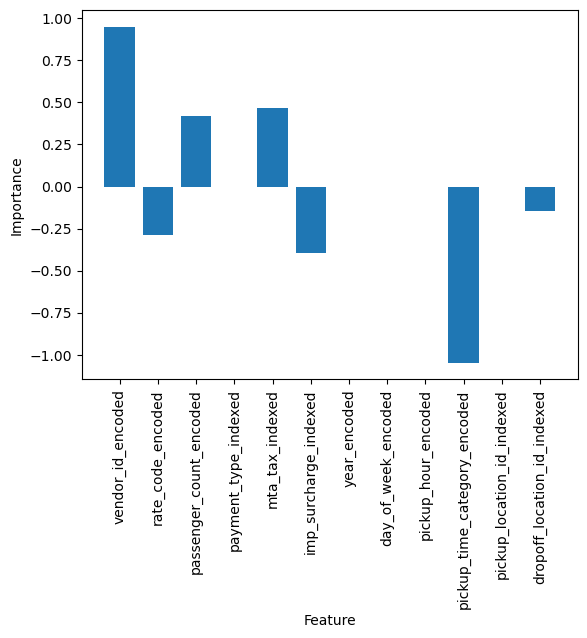

In [67]:
# Get the feature importances from the trained model
coefficients = best_model.coefficients
feature_importances = coefficients.toArray()

# Get the names of the input columns
input_cols = independent_cols[:-1]  # Exclude the scaled numerical features combined together column

# Merge the input column names and their corresponding feature importances
feature_importances_dict = {}
for i, col in enumerate(input_cols):
    feature_importances_dict[col] = feature_importances[i]

# Plot the feature importances using a chart
import matplotlib.pyplot as plt

plt.bar(feature_importances_dict.keys(), feature_importances_dict.values())
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


In [169]:
import builtins

# Get the coefficients of the linear regression model
coefficients = best_model.coefficients

# Get the names of the independent columns
independent_cols = ['vendor_id_encoded', 'rate_code_encoded', 'passenger_count_encoded', 'payment_type_indexed', 'mta_tax_indexed', 'imp_surcharge_indexed', 'year_encoded', 'day_of_week_encoded', 'pickup_hour_encoded', 'pickup_time_category_encoded', 'pickup_location_id_indexed', 'dropoff_location_id_indexed', 'scaled_num_features']

# Create a dictionary to store the feature importance values
feature_importance = {}

# Loop through each independent column and its corresponding coefficient to calculate its feature importance
for i, col_name in enumerate(independent_cols):
    feature_importance[col_name] = builtins.abs(coefficients[i])

# Print the feature importance values in descending order
for col, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print("{}: {}".format(col, importance))


pickup_time_category_encoded: 1.0461000812645387
vendor_id_encoded: 0.9509066866801812
mta_tax_indexed: 0.46458492552601416
passenger_count_encoded: 0.41946753508302476
imp_surcharge_indexed: 0.39502160115553636
rate_code_encoded: 0.28826920967785713
dropoff_location_id_indexed: 0.14502162667373236
payment_type_indexed: 0.0
year_encoded: 0.0
day_of_week_encoded: 0.0
pickup_hour_encoded: 0.0
pickup_location_id_indexed: 0.0
scaled_num_features: 0.0


##### **Feature Importance:**
After fitting the model, we can extract the coefficients of the linear regression model and use them as a measure of feature importance. The higher the absolute value of the coefficient, the stronger the impact of that feature on the target variable (total_amount in this case).

In [170]:
# Get the feature importance from the best model
feature_importance = best_model.coefficients
len(feature_importance)

49

In [171]:
# Make predictions using the best model on test data
predictions = best_model.transform(test_data)

# Get the feature names from the VectorAssembler inputCols parameter
feature_names = assembler.getInputCols()

# Get the feature importance
feature_importance = best_model.coefficients

# Create a dictionary of feature names and their importance
feature_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Print the feature importance
for feature, importance in feature_dict.items():
    print(f"{feature}: {importance}")


vendor_id_encoded: 0.9509066866801812
rate_code_encoded: -0.28826920967785713
passenger_count_encoded: 0.41946753508302476
payment_type_indexed: 0.0
mta_tax_indexed: 0.46458492552601416
imp_surcharge_indexed: -0.39502160115553636
year_encoded: 0.0
day_of_week_encoded: 0.0
pickup_hour_encoded: 0.0
pickup_time_category_encoded: -1.0461000812645387
pickup_location_id_indexed: 0.0
dropoff_location_id_indexed: -0.14502162667373236
scaled_num_features: 0.0


### 6.d.2. Random Forest:

In [159]:
from pyspark.ml.regression import RandomForestRegressor

#Split the data into training and testing sets
train_data, test_data = finalized_data.randomSplit([0.8, 0.2])

#Create the RandomForestRegressor model
# Set the maxBins parameter to a value larger than or equal to the maximum number of categories in your categorical features
rf = RandomForestRegressor(featuresCol='Independent_Features', labelCol='total_amount', numTrees=100, maxBins=260)

#Train the Random Forest regression model
rf_model = rf.fit(train_data)

#Evaluate the model performance on the testing set
predictions = rf_model.transform(test_data)

#Calculate the evaluation metrics
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)
#Feature importance
importances = rf_model.featureImportances
print("Feature importances:\n", importances)

23/05/01 17:03:16 WARN org.apache.spark.ml.tree.impl.DecisionTreeMetadata: DecisionTree reducing maxBins from 260 to 46 (= number of training instances)


Root Mean Squared Error (RMSE) on test data = 6.254776822660716
Feature importances:
 (49,[0,1,2,3,4,5,6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,36,37,38,39,40,41,42,43,44,45,48],[0.00739446936593841,0.000338034201469969,0.01188494944677649,0.008065393978651286,0.0003195590623120424,0.000682730381104635,0.002243370571601835,0.00678115921884193,0.004393841176417902,0.005057788332127199,0.0007361930065056649,0.005320907498450368,0.00019789813946026488,3.8827102656537824e-05,0.004701862631693487,4.615359419877855e-05,0.006982148192152428,0.0008070638769954514,0.006404400787503051,0.0009491902173024396,0.0029010775038111375,8.374062102664835e-05,1.798182984710389e-05,0.00016084743726844052,0.00022345779807598666,0.003832862960180666,0.0001269805207467428,3.9063523909880426e-05,0.0012860744754177732,2.01157903350511e-06,4.0683755745483945e-05,0.0006027730756145802,8.25009919435316e-06,0.0002740622804697816,0.002207705663000316,0.0027699754246257404,0.001548

In [160]:
# Calculate the R-squared metric
r2_evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(predictions)
print("R-squared on test data =", r2)

R-squared on test data = 0.4881194640860249


In [161]:
from pyspark.sql.functions import col
def calculate_mape(test_data, predictions):
    test_data_with_pred = test_data.join(predictions, on=['Independent_Features', 'total_amount'], how='inner')
    mape_df = test_data_with_pred.select(((abs(col('total_amount') - col('prediction')) / col('total_amount')) * 100).alias('mape'))
    total_count = mape_df.count()
    total_mape = mape_df.agg({'mape': 'sum'}).collect()[0][0]
    return total_mape / total_count
mape = calculate_mape(test_data, predictions)
print("Mean Absolute Percentage Error (MAPE) on test data =", mape)

Mean Absolute Percentage Error (MAPE) on test data = 40.520127814706036


In [97]:
print(f"Length of independent_cols: {len(independent_cols)}")
print(f"Length of importances: {len(importances.toArray())}")

Length of independent_cols: 13
Length of importances: 49


In [162]:
import pandas as pd
feature_importances = importances.toArray()
encoded_columns = finalized_data.select("Independent_Features").schema["Independent_Features"].metadata["ml_attr"]["attrs"]["binary"] + finalized_data.select("Independent_Features").schema["Independent_Features"].metadata["ml_attr"]["attrs"]["numeric"]
#df
encoded_importances_df = pd.DataFrame(list(zip([col["name"] for col in encoded_columns], feature_importances)), columns=["Feature", "Importance"])
print(encoded_importances_df)

                                    Feature  Importance
0                       vendor_id_encoded_2    0.007394
1                       rate_code_encoded_1    0.000338
2                 passenger_count_encoded_1    0.011885
3                 passenger_count_encoded_2    0.008065
4                 passenger_count_encoded_3    0.000320
5                 passenger_count_encoded_6    0.000683
6                         year_encoded_2018    0.002243
7                         year_encoded_2019    0.000000
8                         year_encoded_2021    0.000000
9              day_of_week_encoded_Saturday    0.006781
10               day_of_week_encoded_Monday    0.004394
11               day_of_week_encoded_Friday    0.005058
12             day_of_week_encoded_Thursday    0.000736
13               day_of_week_encoded_Sunday    0.005321
14              day_of_week_encoded_Tuesday    0.000198
15                    pickup_hour_encoded_4    0.000039
16                   pickup_hour_encoded_11    0

In [163]:
categorical_features = [
    "vendor_id",
    "rate_code",
    "passenger_count",
    "payment_type",
    "mta_tax",
    "imp_surcharge",
    "year",
    "day_of_week",
    "pickup_hour",
    "pickup_time_category",
    "pickup_location_id",
    "dropoff_location_id"
]

#Aggregate
aggregated_importances = []
for cat_feat in categorical_features:
    aggregated_importance = encoded_importances_df[encoded_importances_df["Feature"].str.startswith(cat_feat)]["Importance"].sum()
    aggregated_importances.append((cat_feat, aggregated_importance))

numeric_features = [
    "scaled_num_features_0",  # trip_distance
    "scaled_num_features_1",  # extra
    "scaled_num_features_2",  # tip_amount
    "scaled_num_features_3",  # tolls_amount
    "scaled_num_features_4",  # airport_fee
    "scaled_num_features_5",  # duration
]
for num_feat in numeric_features:
    aggregated_importances.append((num_feat, encoded_importances_df.loc[encoded_importances_df["Feature"] == num_feat, "Importance"].values[0]))

aggregated_importances_df = pd.DataFrame(aggregated_importances, columns=["Feature", "Importance"])
aggregated_importances_df = aggregated_importances_df.sort_values(by="Importance", ascending=False)

print(aggregated_importances_df)

                  Feature  Importance
17  scaled_num_features_5    0.272417
16  scaled_num_features_4    0.164374
15  scaled_num_features_3    0.160524
8             pickup_hour    0.028644
7             day_of_week    0.022488
2         passenger_count    0.020953
0               vendor_id    0.007394
13  scaled_num_features_1    0.002770
6                    year    0.002243
12  scaled_num_features_0    0.002208
14  scaled_num_features_2    0.001548
9    pickup_time_category    0.000885
1               rate_code    0.000338
5           imp_surcharge    0.000000
10     pickup_location_id    0.000000
11    dropoff_location_id    0.000000
4                 mta_tax    0.000000
3            payment_type    0.000000


In [164]:
#Create a dictionary 
encoded_to_original_names = {
    "scaled_num_features_0": "trip_distance",
    "scaled_num_features_1": "extra",
    "scaled_num_features_2": "tip_amount",
    "scaled_num_features_3": "tolls_amount",
    "scaled_num_features_4": "airport_fee",
    "scaled_num_features_5": "duration"
}

#Update the 'Feature' column 
aggregated_importances_df["Feature"] = aggregated_importances_df["Feature"].replace(encoded_to_original_names)
print(aggregated_importances_df)

                 Feature  Importance
17              duration    0.272417
16           airport_fee    0.164374
15          tolls_amount    0.160524
8            pickup_hour    0.028644
7            day_of_week    0.022488
2        passenger_count    0.020953
0              vendor_id    0.007394
13                 extra    0.002770
6                   year    0.002243
12         trip_distance    0.002208
14            tip_amount    0.001548
9   pickup_time_category    0.000885
1              rate_code    0.000338
5          imp_surcharge    0.000000
10    pickup_location_id    0.000000
11   dropoff_location_id    0.000000
4                mta_tax    0.000000
3           payment_type    0.000000


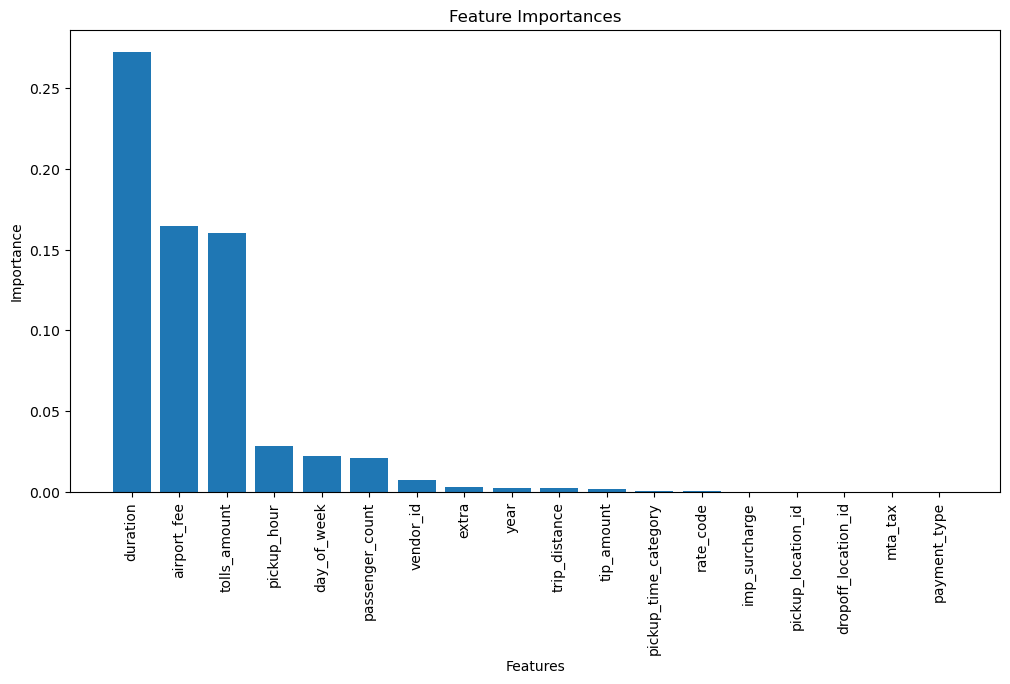

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(aggregated_importances_df["Feature"], aggregated_importances_df["Importance"])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(rotation=90)
plt.show()

### 6.d.3. GBTRegressor:

In [166]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

#Split the data
train_data, test_data = finalized_data.randomSplit([0.8, 0.2])

#Create the GBTRegressor model
gbt = GBTRegressor(featuresCol='Independent_Features', labelCol='total_amount', maxBins=260)

#Train
gbt_model = gbt.fit(train_data)

#Evaluate the model 
predictions = gbt_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

23/05/01 17:04:21 WARN org.apache.spark.ml.tree.impl.DecisionTreeMetadata: DecisionTree reducing maxBins from 260 to 49 (= number of training instances)


Root Mean Squared Error (RMSE) on test data = 18.10462378361858


In [167]:
# Calculate the R-squared metric
r2_evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(predictions)
print("R-squared on test data =", r2)

R-squared on test data = -23.13416830384304


In [168]:
from pyspark.sql.functions import col

# Define a function to calculate the Mean Absolute Percentage Error (MAPE)
def calculate_mape(test_data, predictions):
    test_data_with_pred = test_data.join(predictions, on=['Independent_Features', 'total_amount'], how='inner')
    mape_df = test_data_with_pred.select(((abs(col('total_amount') - col('prediction')) / col('total_amount')) * 100).alias('mape'))
    total_count = mape_df.count()
    total_mape = mape_df.agg({'mape': 'sum'}).collect()[0][0]
    return total_mape / total_count

# Calculate the MAPE on test data
mape = calculate_mape(test_data, predictions)
print("Mean Absolute Percentage Error (MAPE) on test data =", mape)

Mean Absolute Percentage Error (MAPE) on test data = 114.54368701975697


#### **Summary of Different Model Metrics::**

| Model | RMSE | R2 | MAPE | Interpretation |
| --- | --- | --- | --- | --- |
| Linear Regression | 1.39 | 0.99 | 6.93% | Accurate predictions with high proportion of explained variance and good overall fit to the data. |
| Random Forest | 6.25 | 0.49 | 40.52% | Less accurate predictions with lower proportion of explained variance and poorer overall fit to the data. |
| GBTRegressor | 18.10 | -23.13 | 114.54% | Least accurate predictions with negative R-squared indicating worse performance than the mean value of the target variable, and very poor overall fit to the data. |

In conclusion, for the ML part  the Linear Regression model outperformed the other two models, with accurate predictions, high R-squared, and low MAPE. Random Forest had higher errors and lower R-squared, indicating weaker performance. GBTRegressor performed the worst with very high errors, negative R-squared, and poor overall fit to the data.

Thus, we can conclude from ML part that the Linear Regression model performed the best, with low RMSE, high R-squared, and low MAPE. Random Forest had higher errors and lower R-squared, indicating weaker performance. GBTRegressor performed the worst with very high errors and negative R-squared, indicating a poor fit to the data.

## **7. Challenges**

* **Challenges with large datasets were solved via encoding, scaling, and vectorizing.**

We encountered challenges while working with a large dataset with various features. To overcome these challenges, we numerically encoded nominal categorical features using String Indexer and applied one-hot encoding to ordinal categorical features to reduce bias in the regression model. We also used the robust scaler technique to scale numerical features and avoid feature dominance or bias issues. We did not scale or normalize the target variable as it represented the actual value we wanted to predict. Finally, we used feature vectors to create a sparse matrix to combine the categorical and scaled numerical features for our model input.
* **Not generalizable to the entire dataset:** 

Due to the large dataset size, a small sample was used to build the regression models. This may limit the model's representativeness and accuracy, as important patterns or relationships may be missed. Additionally, the model may not generalize well to new data, as it was trained on only a small portion of the available data and may not fully represent the entire population. Therefore, caution should be exercised when using this model to make predictions or inform decision-making.
* **Critical external factors missing from the dataset:** 

One challenge with predicting total_amount in the given dataset is the absence of potentially essential features such as the route taken by the taxi, weather, and traffic conditions during the trip. These factors could significantly impact the fare amount and total revenue earned per trip, but their absence makes it difficult to build an accurate predictive model.

## **8. Conclusion**

* **Explaratory Data Analysis** 

Based on the data analysis conducted, it is evident that demand for taxi trips in New York City was significantly impacted by the COVID-19 pandemic. While this conclusion is self-evident, our data shows that demand for taxis after March 2020 plummeted. However, our data also indicates that there has been a steady increase in demand since 2021. 

The analysis also revealed that taxi trips were most popular during the morning and afternoon hours, with demand decreasing significantly during the late evening and night hours. In terms of trip length, short-distance trips were the most popular, with the most frequently traveled routes being in the upper east and upper west side, spanning 66 blocks. Additionally, long trips were found to be the most expensive per minute, followed by shorter trips and medium-length trips, which had the lowest cost per minute.

In terms of difference in demand based on the day of the week; Friday has the highest demand, while Sunday has the lowest. If drivers want to make more money, they may not take business on these two days because Friday may see congestion, and you may only take a few customers on Sunday. 

* **Machine Learning**

In terms of performance, we evaluated three ML models on our dataset: Linear Regression, Random Forest, and GBTRegressor. The Linear Regression model outperformed the other models with accurate predictions, high R-squared, and low MAPE. On the other hand, Random Forest had higher errors and lower R-squared, indicating weaker performance. GBTRegressor performed the worst with very high errors, negative R-squared, and poor overall fit to the data.
Based on our evaluation, we recommend using Linear Regression as the preferred model for this dataset due to its superior performance compared to the other models. However, it is essential to note that the choice of the best model depends on the specific problem and dataset characteristics, and the performance of the models may vary depending on various factors. Therefore, it is recommended to interpret the model performance with a grain of salt and consider the study's specific context and limitations.

In addition, our ML model revealed some important factors that drive taxi trip earnings, such as duration, airport fee, and tolls amount, as well as passenger count, pickup hour, and day of the week. However, it's important to note that the analysis could be further improved by including additional features such as weather and traffic conditions, which were not included in our dataset. Nonetheless, these insights can provide some valuable guidance for decision-making for both taxi drivers and vendors